# Resample Images to DSM Grid Over Glacier

In [117]:
import rasterio as rio
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
from rasterio.warp import reproject, Resampling
from osgeo import gdal
import shutil

### Read in DSM

In [118]:
##############
dempath = '/Volumes/SGlacier/IfSAR_5m_DSM_clipped.tif'
##############

In [119]:
dsm = rio.open(dempath) # open using rasterio
elev = dsm.read(1) # read in the first and only band (elevations)

In [120]:
# grab the x and y grid values for the DSM
dsm_x = np.linspace(dsm.bounds.left, dsm.bounds.right, num=np.shape(elev)[1])
dsm_y = np.linspace(dsm.bounds.top, dsm.bounds.bottom, num=np.shape(elev)[0])

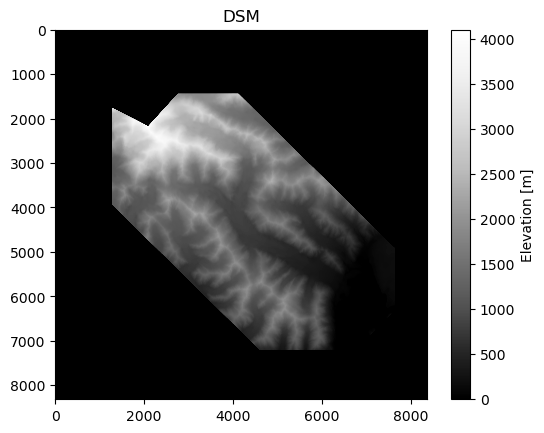

In [121]:
# Display the DSM
fig, ax1 = plt.subplots(1,1)
hs_im = ax1.imshow(elev, cmap='Greys_r', vmin=0)
ax1.set_title('DSM')
# ax1.set_xlabel('Easting [m]')
# ax1.set_ylabel('Northing [m]')
fig.colorbar(hs_im, ax=ax1,label='Elevation [m]')
plt.show()

### Interpolate 1 image to DSM grid

In [63]:
imgpath = '/Users/maddiegendreau/Desktop/Test2_Download/' # path to a test image
imgname = '20220624_194605_57_225a_3B_AnalyticMS_SR_clip.tif' # image filename
# img = rio.open(imgpath+imgname) # open using rasterio
# nir = img.read(4) # grab the NIR band, 4

if not os.path.exists(imgpath + 'reprojected/'):
    os.mkdir(imgpath + 'reprojected/')

raster = gdal.Open(imgpath + imgname)
projstg = raster.GetProjection()
imgcrs = projstg.split('EPSG')[-1][3:8]
print(imgcrs)
print(dsm.crs)

if 'EPSG:' + imgcrs != str(dsm.crs):
    gdal.Warp(imgpath + 'reprojected/' + imgname, imgpath + imgname, dstSRS=str(dsm.crs))
    print('reprojecting' + imgname)
else:
    shutil.copy(imgpath + imgname, imgpath + 'reprojected/'+ imgname)

# with rio.open(imgpath + imgname) as img:
#     if img.crs != dsm.crs:    
#         nir = img.read(4) # grab the NIR band, 4
#         print ('reprojecting')
#         img, dest_transform = reproject(source=nir,
#                 destination=elev,
#                 src_transform=img.transform,
#                 src_crs=img.crs,
#                 dst_transform=dsm.transform,
#                 dst_crs=dsm.crs,
#                 resampling=Resampling.nearest)
        
#         with rio.open(imgpath+imgname,'w',
#                   driver='GTiff',
#                   height=nir.shape[0],
#                   width=nir.shape[1],
#                   dtype=nir.dtype,
#                   count=1,
#                   crs=dsm.crs,
#                   transform=dsm.transform) as dst:
#             dst.write(img, 1)

img = rio.open(imgpath+'reprojected/'+imgname) # open using rasterio
img_data = img.read() # grab the NIR band, 4

print(len(img_data))
if len(img_data) == 4:
    nir = img_data[3]
elif len(img_data) == 1:
    nir = img_data[0]

print("Image dimensions:",nir.shape)
# grab the x and y grid values for the DSM
img_x = np.linspace(img.bounds.left, img.bounds.right, num=np.shape(nir)[1])
img_y = np.linspace(img.bounds.top, img.bounds.bottom, num=np.shape(nir)[0])

32607
EPSG:32608
reprojecting20220624_194605_57_225a_3B_AnalyticMS_SR_clip.tif
4
Image dimensions: (7828, 13448)


In [44]:
imgpath = '/Users/maddiegendreau/Desktop/Test_Download/' # path to a test image
imgname = '20220624_193456_86_241f_3B_AnalyticMS_SR_clip.tif' # image filename

raster = gdal.Open(imgpath + imgname)
projstg = raster.GetProjection()
imgcrs = projstg.split('EPSG')[-1][3:8]
print(imgcrs)

32608


In [24]:
f = interp2d(img_x, img_y, nir) # create img interpolation object
nir_resamp = np.zeros(np.shape(elev)) # initialize resampled image with DSM shape
nir_resamp = f(dsm_x,dsm_y) # resample the NIR data to the DSM coordinates
nir_resamp = np.flipud(nir_resamp) # flip up down
print("Resample to DSM dimensions:",elev.shape)

Resample to DSM dimensions: (5800, 6381)


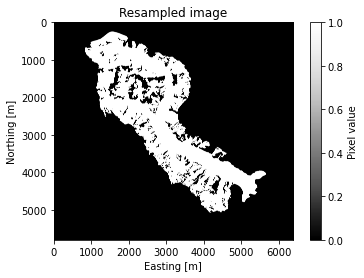

In [25]:
# Display the resampled image
fig, ax1 = plt.subplots(1,1)
plot = ax1.imshow(nir_resamp, cmap='Greys_r')
ax1.set_title('Resampled image')
ax1.set_xlabel('Easting [m]')
ax1.set_ylabel('Northing [m]')
fig.colorbar(plot, ax=ax1,label='Pixel value')
plt.show()

In [112]:
img.transform

Affine(3.0, 0.0, 545913.0,
       0.0, -3.0, 6682902.0)

In [26]:
# save the resampled image to georeferenced tif file
outfile = imgname[:-4]+'_5m.tif' # generate new filename with 5m suffix
print("Save resampled image to", outfile)
with rio.open(imgpath+outfile,'w',
                  driver='GTiff',
                  height=nir_resamp.shape[0],
                  width=nir_resamp.shape[1],
                  dtype=nir_resamp.dtype,
                  count=1,
                  crs=dsm.crs,
                  transform=dsm.transform) as dst:
        dst.write(nir_resamp, 1)

Save resampled image to gm2_5m.tif


# Interpolate all images in a folder to DSM

20201105_191427_54_106c_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (7863, 9722)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201105_191427_54_106c_3B_AnalyticMS_SR_clip_5m.tif
20201105_191427_54_106c_3B_AnalyticMS_SR_clip.tif resampled
0.0 40766.633458737255


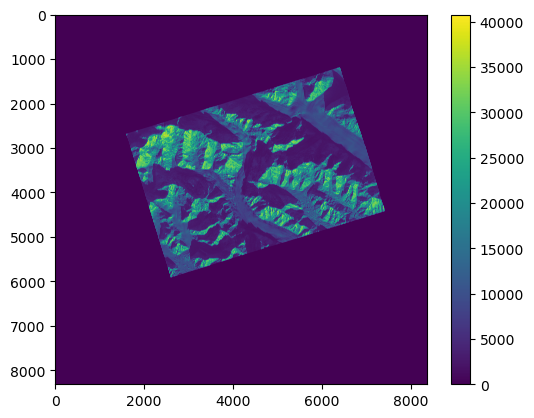

20201113_201328_101b_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4920, 3543)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201113_201328_101b_3B_AnalyticMS_SR_clip_5m.tif
20201113_201328_101b_3B_AnalyticMS_SR_clip.tif resampled
0.0 10061.323081967323


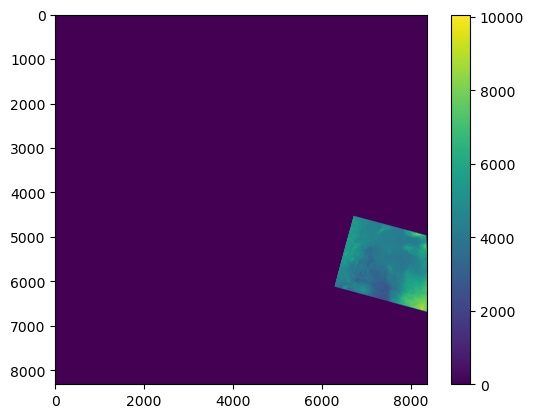

20201109_201627_101b_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (5011, 401)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201109_201627_101b_3B_AnalyticMS_SR_clip_5m.tif
20201109_201627_101b_3B_AnalyticMS_SR_clip.tif resampled
0.0 9776.23467396212


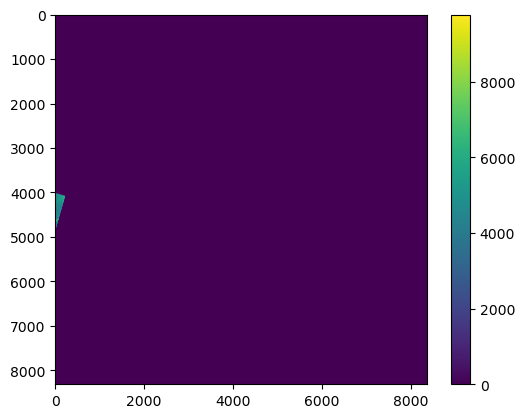

20201117_201553_0f34_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (3951, 5793)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201117_201553_0f34_3B_AnalyticMS_SR_clip_5m.tif
20201117_201553_0f34_3B_AnalyticMS_SR_clip.tif resampled
0.0 38713.273345509624


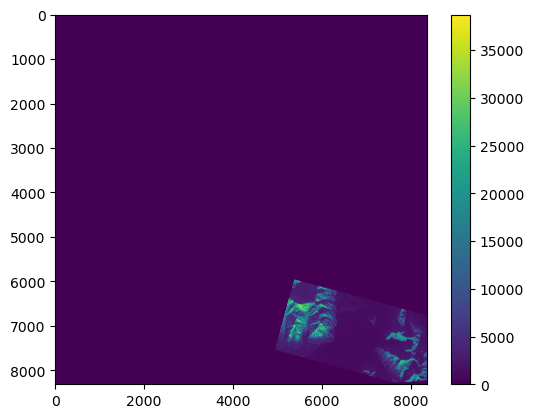

20201101_201047_1004_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (104, 3061)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201101_201047_1004_3B_AnalyticMS_SR_clip_5m.tif
20201101_201047_1004_3B_AnalyticMS_SR_clip.tif resampled
0.0 7462.971621372818


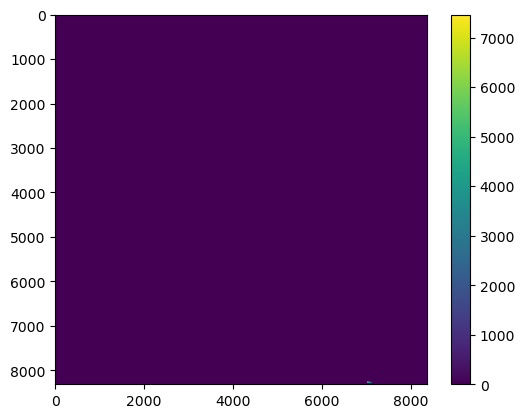

20201107_201154_101f_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (3497, 7608)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201107_201154_101f_3B_AnalyticMS_SR_clip_5m.tif
20201107_201154_101f_3B_AnalyticMS_SR_clip.tif resampled
0.0 26363.76998811316


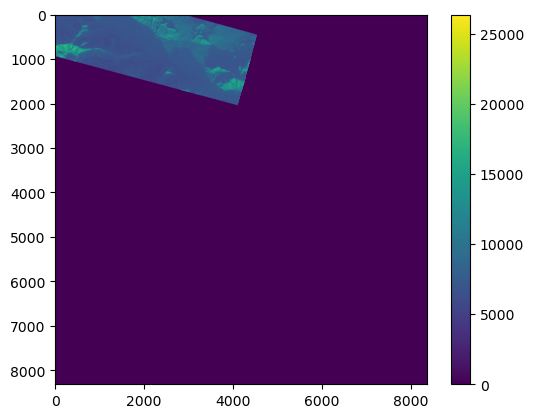

20201120_201800_1013_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4763, 8671)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201120_201800_1013_3B_AnalyticMS_SR_clip_5m.tif
20201120_201800_1013_3B_AnalyticMS_SR_clip.tif resampled
0.0 35983.16122887096


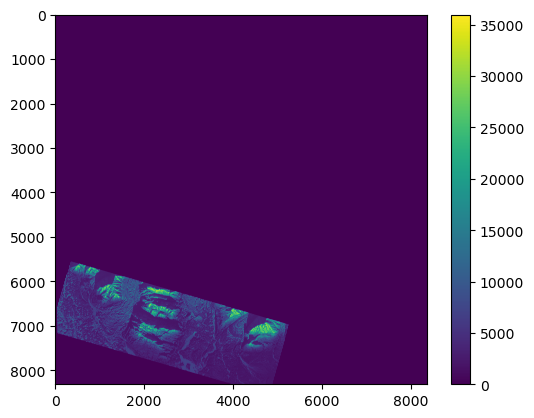

20201105_201600_1035_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (371, 7002)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201105_201600_1035_3B_AnalyticMS_SR_clip_5m.tif
20201105_201600_1035_3B_AnalyticMS_SR_clip.tif resampled
0.0 0.0


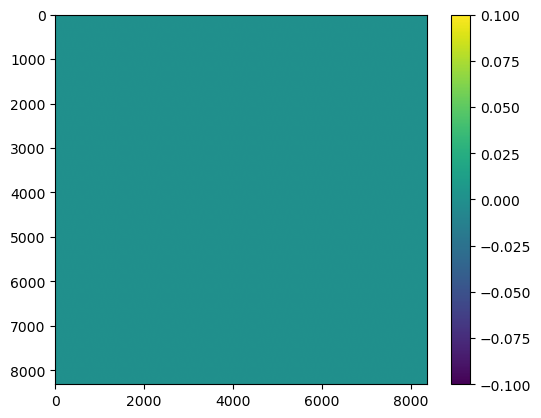

20201116_201453_1034_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4882, 8877)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201116_201453_1034_3B_AnalyticMS_SR_clip_5m.tif
20201116_201453_1034_3B_AnalyticMS_SR_clip.tif resampled
0.0 41813.86836381298


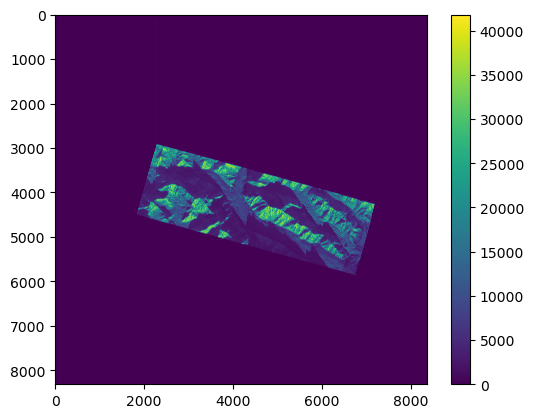

20201107_194759_61_2231_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (328, 10356)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201107_194759_61_2231_3B_AnalyticMS_SR_clip_5m.tif
20201107_194759_61_2231_3B_AnalyticMS_SR_clip.tif resampled
0.0 6929.987956554792


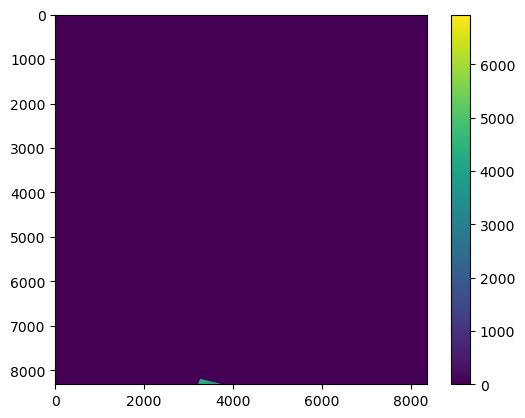

20201120_201757_1013_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4980, 8921)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201120_201757_1013_3B_AnalyticMS_SR_clip_5m.tif
20201120_201757_1013_3B_AnalyticMS_SR_clip.tif resampled
0.0 42686.161952245275


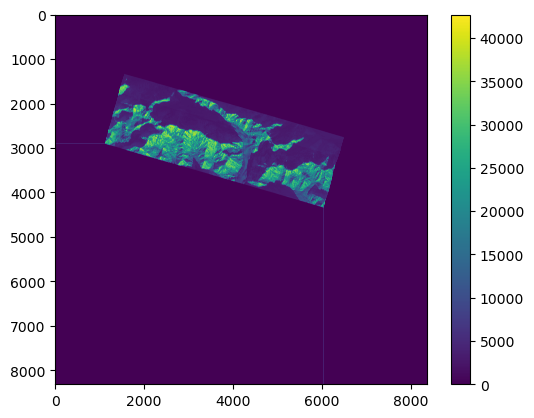

20201105_204249_66_1058_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (2135, 1031)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201105_204249_66_1058_3B_AnalyticMS_SR_clip_5m.tif
20201105_204249_66_1058_3B_AnalyticMS_SR_clip.tif resampled
0.0 0.0


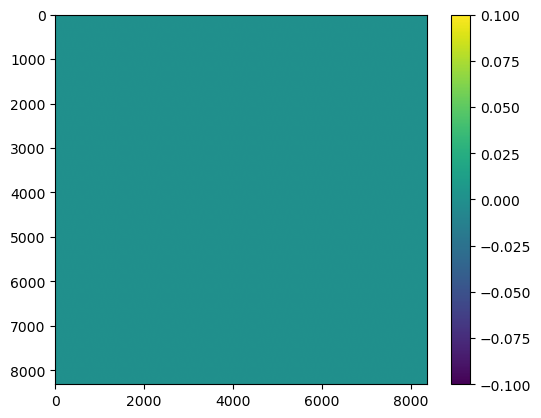

20201116_201455_1034_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4498, 8933)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201116_201455_1034_3B_AnalyticMS_SR_clip_5m.tif
20201116_201455_1034_3B_AnalyticMS_SR_clip.tif resampled
0.0 42163.0964308752


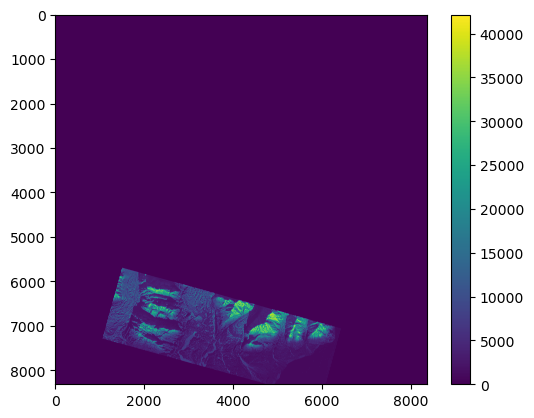

20201107_201158_101f_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4928, 4996)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201107_201158_101f_3B_AnalyticMS_SR_clip_5m.tif
20201107_201158_101f_3B_AnalyticMS_SR_clip.tif resampled
0.0 28901.483953583796


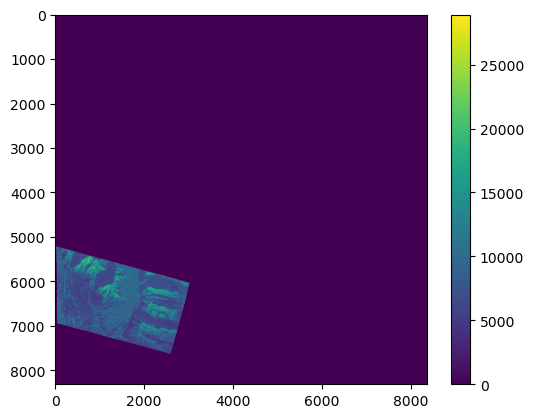

20201110_201456_1032_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4935, 8921)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201110_201456_1032_3B_AnalyticMS_SR_clip_5m.tif
20201110_201456_1032_3B_AnalyticMS_SR_clip.tif resampled
0.0 38110.7029958223


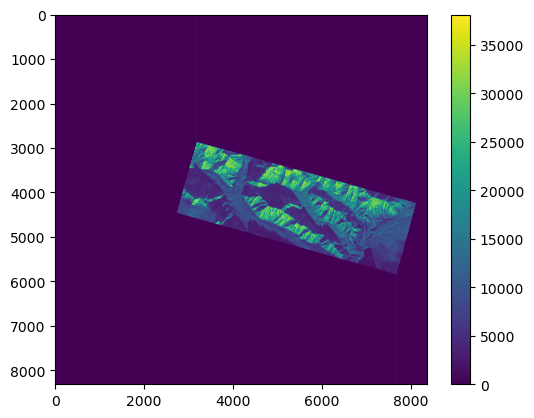

20201106_204450_74_105e_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (3760, 6953)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201106_204450_74_105e_3B_AnalyticMS_SR_clip_5m.tif
20201106_204450_74_105e_3B_AnalyticMS_SR_clip.tif resampled
0.0 29540.948333007334


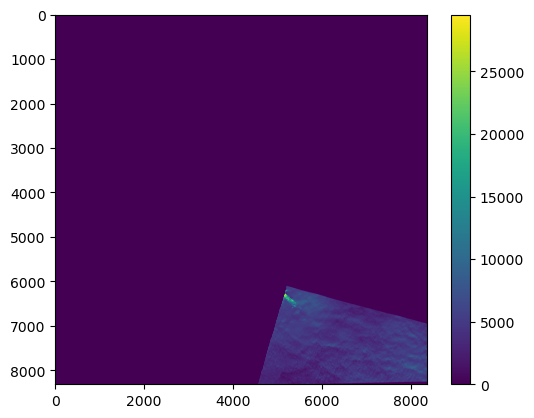

20201106_205311_69_1066_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (5578, 3796)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201106_205311_69_1066_3B_AnalyticMS_SR_clip_5m.tif
20201106_205311_69_1066_3B_AnalyticMS_SR_clip.tif resampled
0.0 18987.068766872682


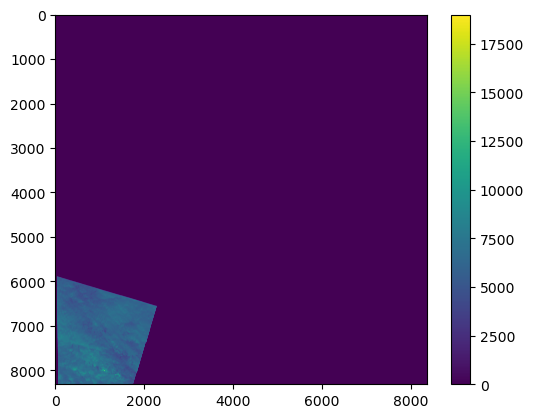

20201112_201754_1034_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (1682, 7660)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201112_201754_1034_3B_AnalyticMS_SR_clip_5m.tif
20201112_201754_1034_3B_AnalyticMS_SR_clip.tif resampled
0.0 11111.388308528856


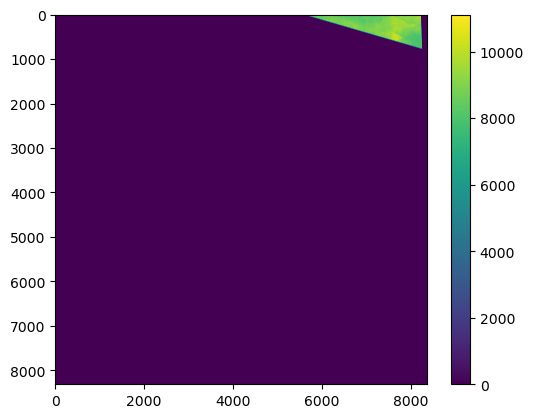

20201115_203823_82_2307_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (5345, 5949)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201115_203823_82_2307_3B_AnalyticMS_SR_clip_5m.tif
20201115_203823_82_2307_3B_AnalyticMS_SR_clip.tif resampled
0.0 33836.5965043079


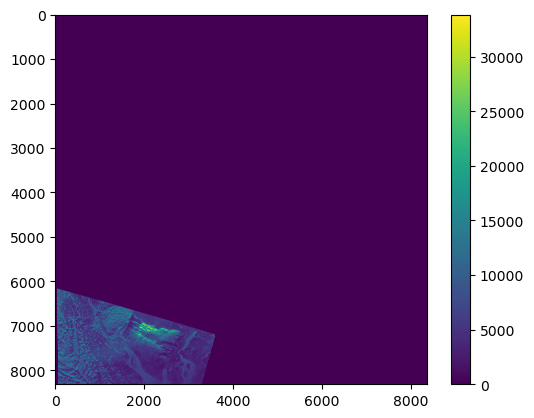

20201116_201607_1002_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (2752, 8407)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201116_201607_1002_3B_AnalyticMS_SR_clip_5m.tif
20201116_201607_1002_3B_AnalyticMS_SR_clip.tif resampled
0.0 26666.059054351143


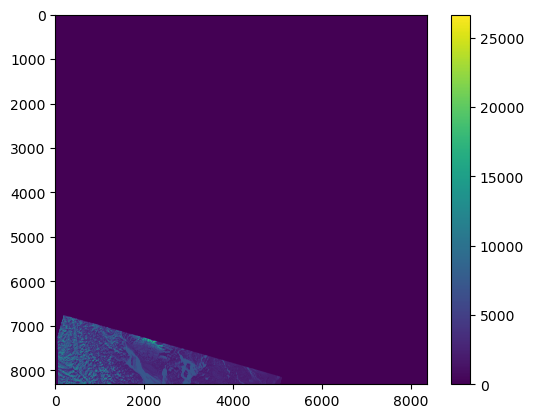

20201107_195901_01_2279_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (6119, 11829)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201107_195901_01_2279_3B_AnalyticMS_SR_clip_5m.tif
20201107_195901_01_2279_3B_AnalyticMS_SR_clip.tif resampled
0.0 19844.28057506567


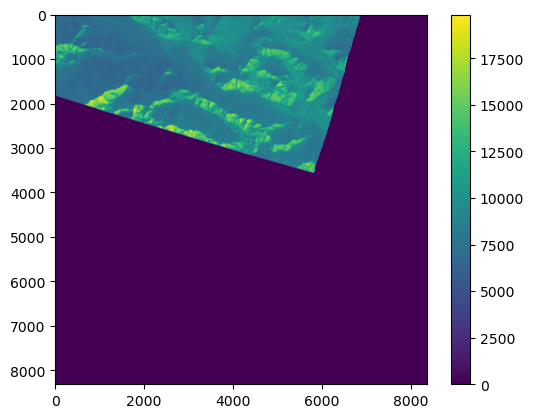

20201107_195905_52_2279_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (8266, 8689)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201107_195905_52_2279_3B_AnalyticMS_SR_clip_5m.tif
20201107_195905_52_2279_3B_AnalyticMS_SR_clip.tif resampled
0.0 21088.864141603222


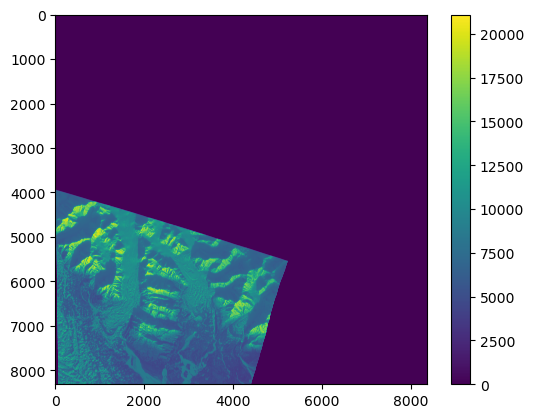

20201116_201910_1040_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (5103, 3619)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201116_201910_1040_3B_AnalyticMS_SR_clip_5m.tif
20201116_201910_1040_3B_AnalyticMS_SR_clip.tif resampled
0.0 46413.50108989274


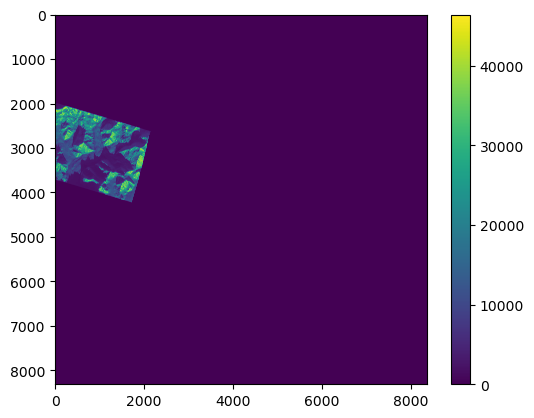

20201105_191430_57_106c_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (3004, 9725)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201105_191430_57_106c_3B_AnalyticMS_SR_clip_5m.tif
20201105_191430_57_106c_3B_AnalyticMS_SR_clip.tif resampled
0.0 39143.70042281626


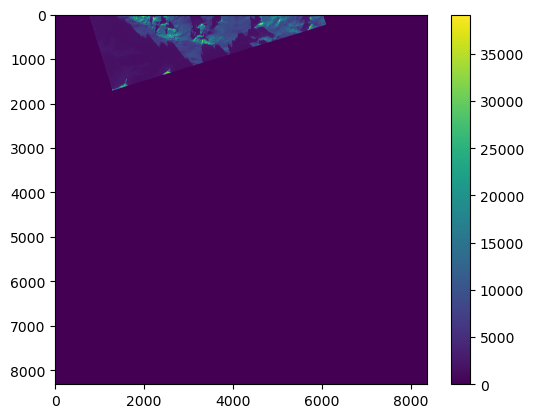

20201115_204701_76_1060_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (1931, 6245)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201115_204701_76_1060_3B_AnalyticMS_SR_clip_5m.tif
20201115_204701_76_1060_3B_AnalyticMS_SR_clip.tif resampled
0.0 23048.422714033386


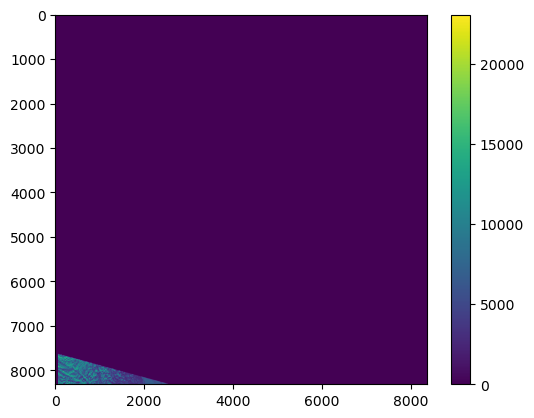

20201104_203723_43_2307_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (9437, 13632)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201104_203723_43_2307_3B_AnalyticMS_SR_clip_5m.tif
20201104_203723_43_2307_3B_AnalyticMS_SR_clip.tif resampled
0.0 37242.8522882463


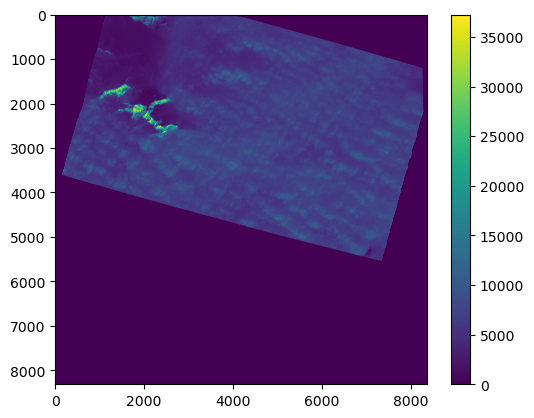

20201116_201909_1040_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4592, 4215)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201116_201909_1040_3B_AnalyticMS_SR_clip_5m.tif
20201116_201909_1040_3B_AnalyticMS_SR_clip.tif resampled
0.0 47271.46360200044


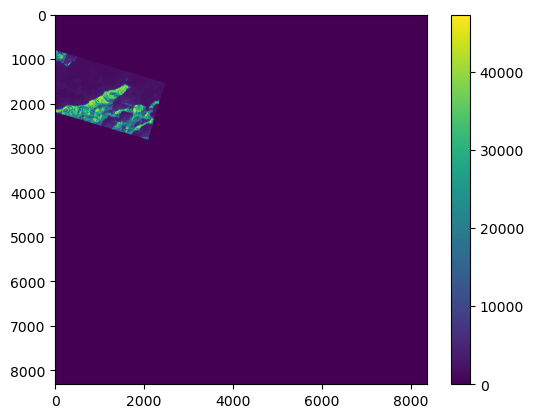

20201113_202033_1026_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (1592, 7567)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201113_202033_1026_3B_AnalyticMS_SR_clip_5m.tif
20201113_202033_1026_3B_AnalyticMS_SR_clip.tif resampled
0.0 24942.04924097697


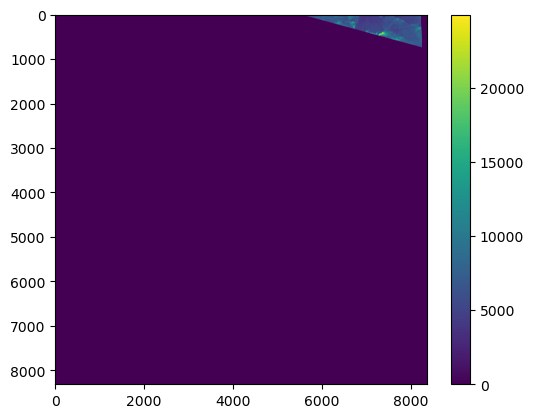

20201102_201458_0f15_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4575, 1610)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201102_201458_0f15_3B_AnalyticMS_SR_clip_5m.tif
20201102_201458_0f15_3B_AnalyticMS_SR_clip.tif resampled
0.0 25816.653138341502


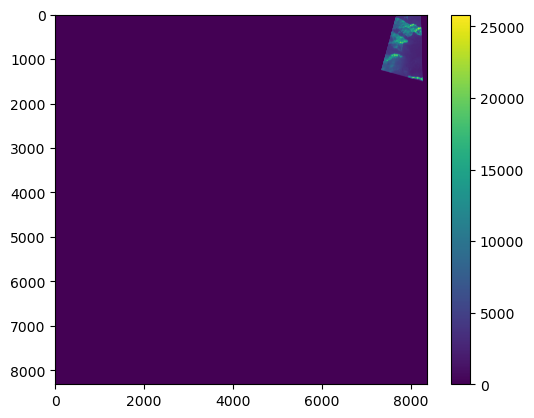

20201105_191422_99_106c_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (1574, 8147)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201105_191422_99_106c_3B_AnalyticMS_SR_clip_5m.tif
20201105_191422_99_106c_3B_AnalyticMS_SR_clip.tif resampled
0.0 31140.027559133236


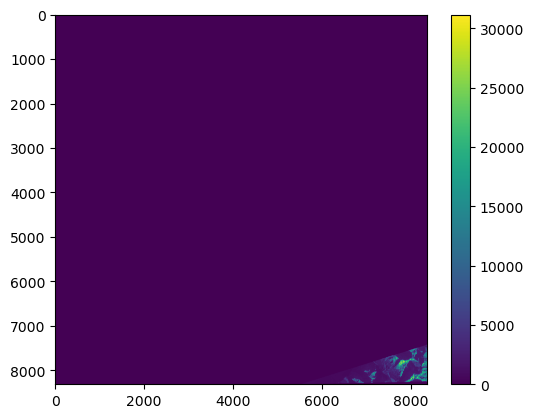

20201113_202035_1026_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4772, 8699)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201113_202035_1026_3B_AnalyticMS_SR_clip_5m.tif
20201113_202035_1026_3B_AnalyticMS_SR_clip.tif resampled
0.0 23074.183817386816


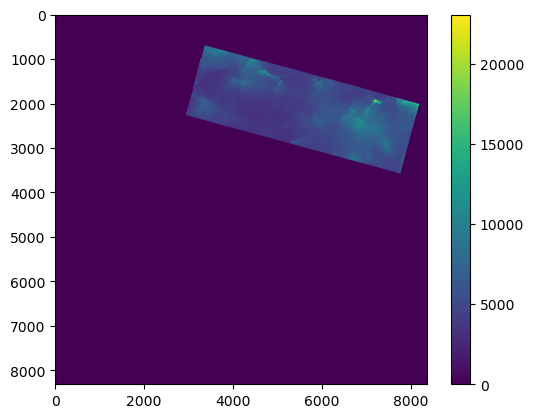

20201105_201557_1035_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4923, 8872)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201105_201557_1035_3B_AnalyticMS_SR_clip_5m.tif
20201105_201557_1035_3B_AnalyticMS_SR_clip.tif resampled
0.0 36272.60277390931


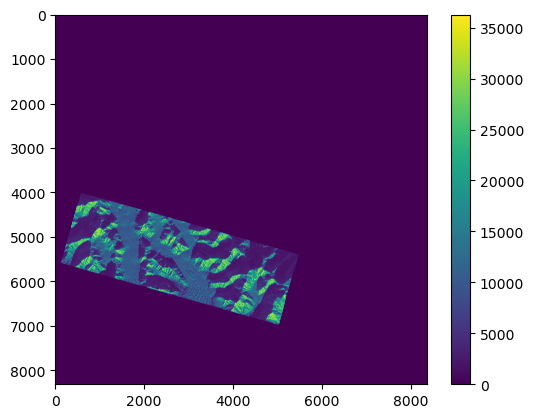

20201115_203816_71_2307_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (3089, 10583)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201115_203816_71_2307_3B_AnalyticMS_SR_clip_5m.tif
20201115_203816_71_2307_3B_AnalyticMS_SR_clip.tif resampled
0.0 40637.07199035034


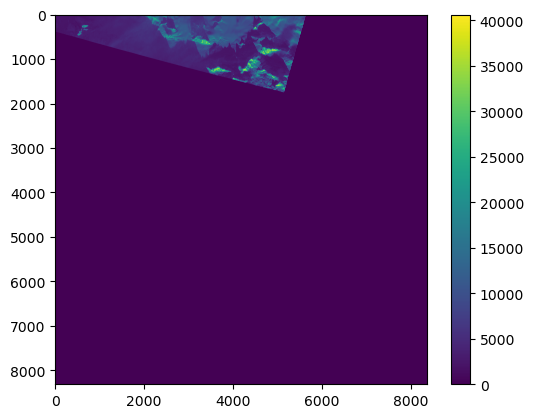

20201104_203541_11_227a_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (10322, 3205)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201104_203541_11_227a_3B_AnalyticMS_SR_clip_5m.tif
20201104_203541_11_227a_3B_AnalyticMS_SR_clip.tif resampled
0.0 11853.612918275763


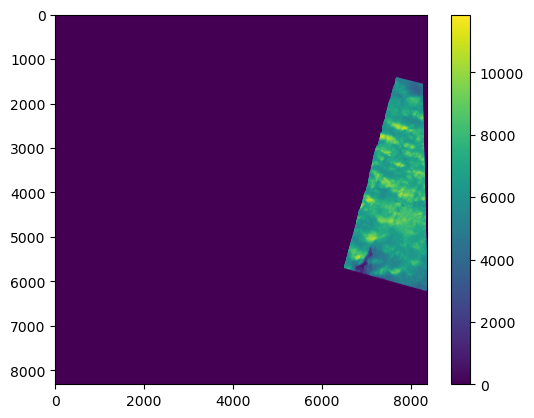

20201115_203631_19_227a_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (6983, 9233)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201115_203631_19_227a_3B_AnalyticMS_SR_clip_5m.tif
20201115_203631_19_227a_3B_AnalyticMS_SR_clip.tif resampled
0.0 42787.28176324322


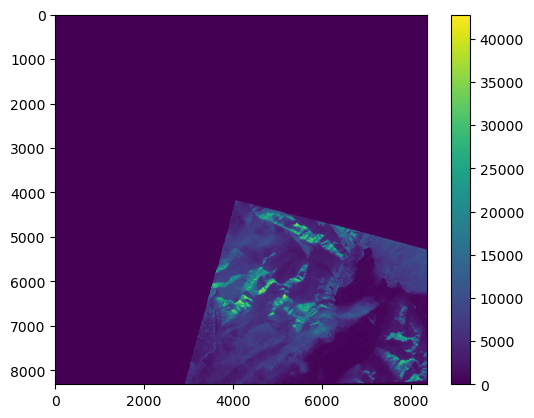

20201120_201801_1013_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (2460, 7981)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201120_201801_1013_3B_AnalyticMS_SR_clip_5m.tif
20201120_201801_1013_3B_AnalyticMS_SR_clip.tif resampled
0.0 23583.142664765157


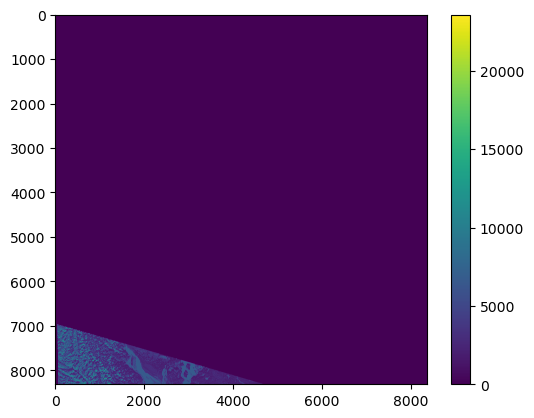

20201109_203753_72_2407_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (1496, 7810)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201109_203753_72_2407_3B_AnalyticMS_SR_clip_5m.tif
20201109_203753_72_2407_3B_AnalyticMS_SR_clip.tif resampled
0.0 13903.6559214442


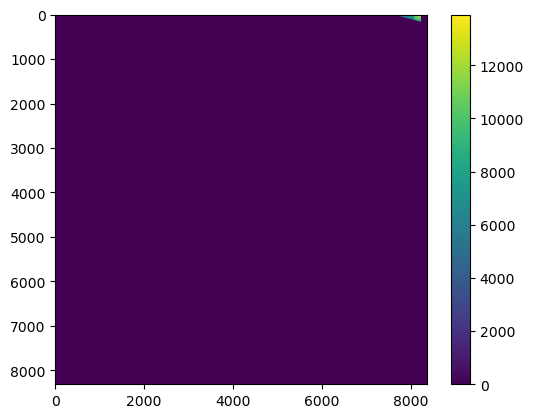

20201101_201046_1004_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (2411, 2440)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201101_201046_1004_3B_AnalyticMS_SR_clip_5m.tif
20201101_201046_1004_3B_AnalyticMS_SR_clip.tif resampled
0.0 9781.968593457766


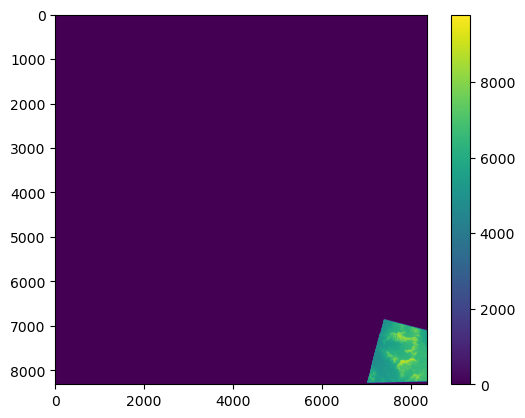

20201107_201155_101f_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4914, 6961)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201107_201155_101f_3B_AnalyticMS_SR_clip_5m.tif
20201107_201155_101f_3B_AnalyticMS_SR_clip.tif resampled
0.0 21384.84270623752


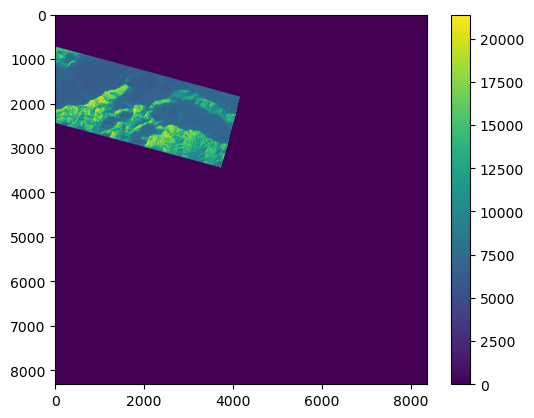

20201117_201554_0f34_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (1589, 6465)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201117_201554_0f34_3B_AnalyticMS_SR_clip_5m.tif
20201117_201554_0f34_3B_AnalyticMS_SR_clip.tif resampled
0.0 28478.676231397247


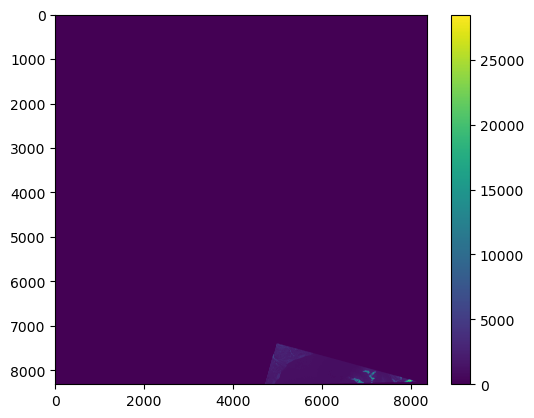

20201117_201552_0f34_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4948, 5124)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201117_201552_0f34_3B_AnalyticMS_SR_clip_5m.tif
20201117_201552_0f34_3B_AnalyticMS_SR_clip.tif resampled
0.0 33950.237299357774


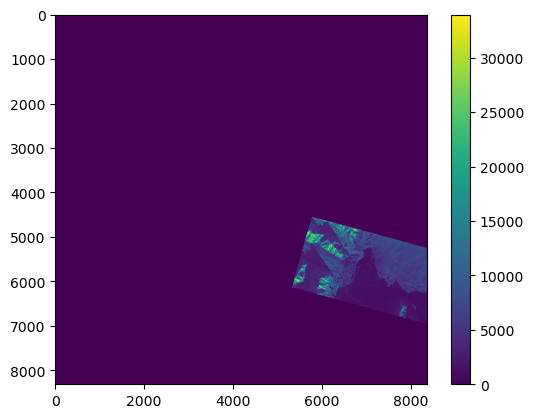

20201107_201153_101f_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (1205, 8289)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201107_201153_101f_3B_AnalyticMS_SR_clip_5m.tif
20201107_201153_101f_3B_AnalyticMS_SR_clip.tif resampled
0.0 16097.471318434995


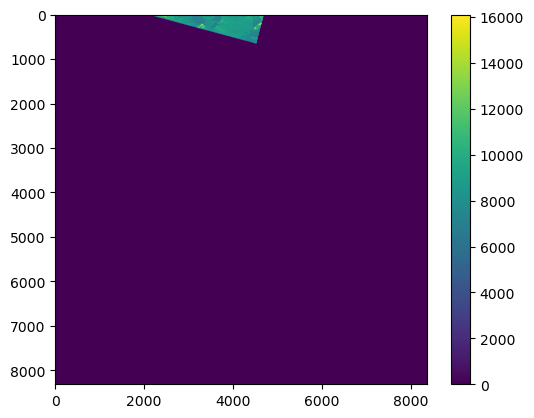

20201109_201626_101b_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4998, 1078)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201109_201626_101b_3B_AnalyticMS_SR_clip_5m.tif
20201109_201626_101b_3B_AnalyticMS_SR_clip.tif resampled
0.0 13622.762588266527


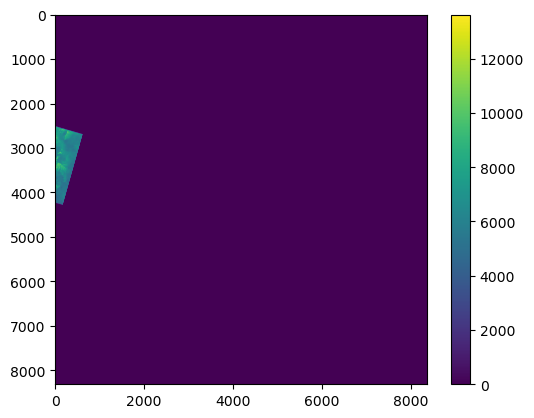

20201107_201159_101f_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (3839, 4346)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201107_201159_101f_3B_AnalyticMS_SR_clip_5m.tif
20201107_201159_101f_3B_AnalyticMS_SR_clip.tif resampled
0.0 25710.09938227373


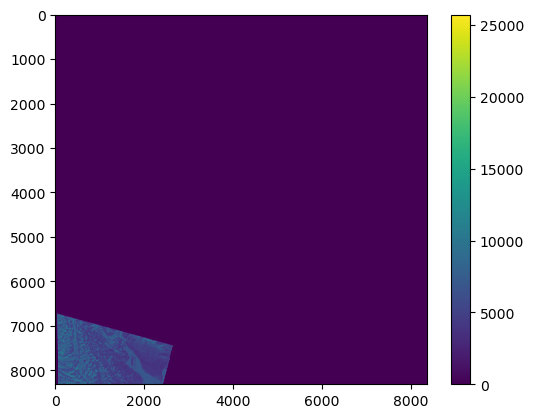

20201116_201454_1034_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4897, 8896)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201116_201454_1034_3B_AnalyticMS_SR_clip_5m.tif
20201116_201454_1034_3B_AnalyticMS_SR_clip.tif resampled
0.0 42314.829779106614


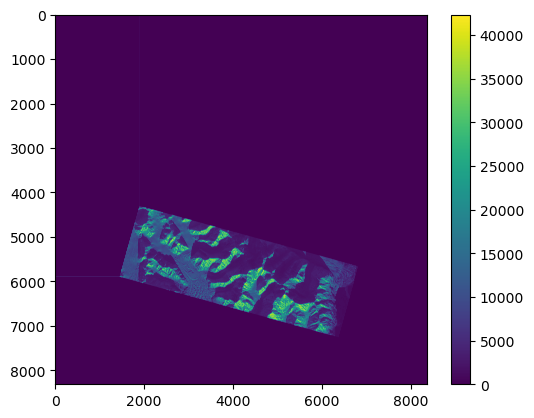

20201120_201756_1013_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (5051, 8996)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201120_201756_1013_3B_AnalyticMS_SR_clip_5m.tif
20201120_201756_1013_3B_AnalyticMS_SR_clip.tif resampled
0.0 40806.14493101148


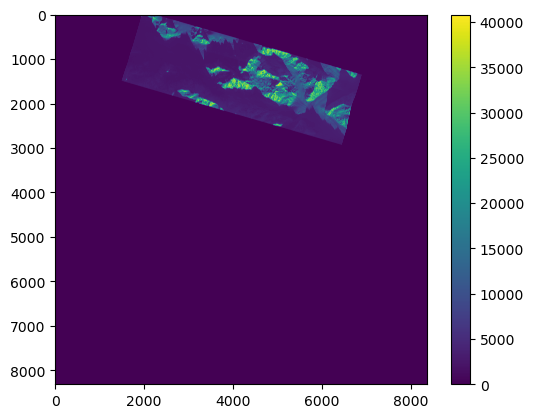

20201104_203728_17_2307_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4374, 11138)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201104_203728_17_2307_3B_AnalyticMS_SR_clip_5m.tif
20201104_203728_17_2307_3B_AnalyticMS_SR_clip.tif resampled
0.0 14289.646150406723


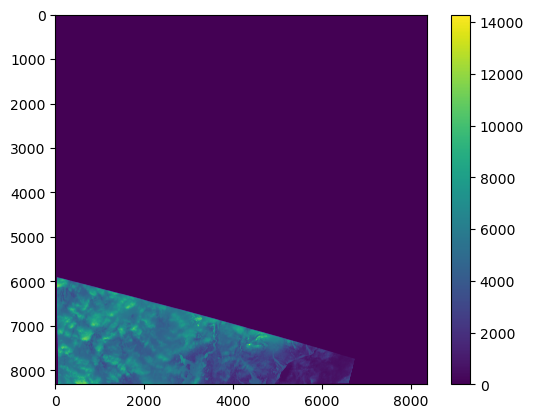

20201110_201457_1032_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4944, 8929)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201110_201457_1032_3B_AnalyticMS_SR_clip_5m.tif
20201110_201457_1032_3B_AnalyticMS_SR_clip.tif resampled
0.0 39303.76617371754


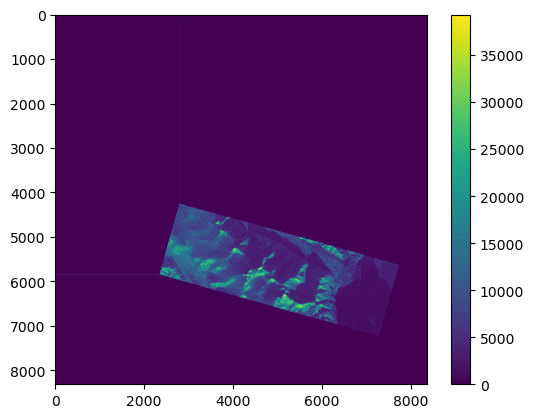

20201105_191426_02_106c_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (7881, 9739)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201105_191426_02_106c_3B_AnalyticMS_SR_clip_5m.tif
20201105_191426_02_106c_3B_AnalyticMS_SR_clip.tif resampled
0.0 44297.61298343586


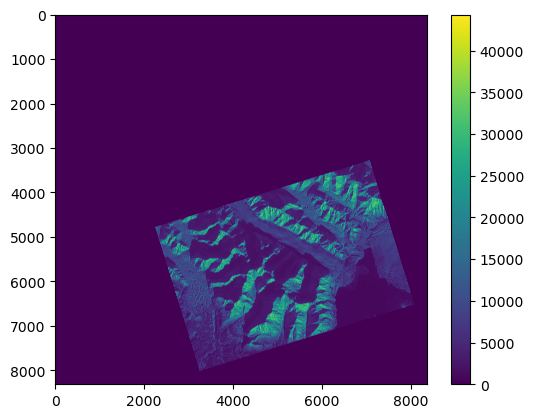

20201101_191529_78_106c_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (535, 8839)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201101_191529_78_106c_3B_AnalyticMS_SR_clip_5m.tif
20201101_191529_78_106c_3B_AnalyticMS_SR_clip.tif resampled
0.0 6866.198483100677


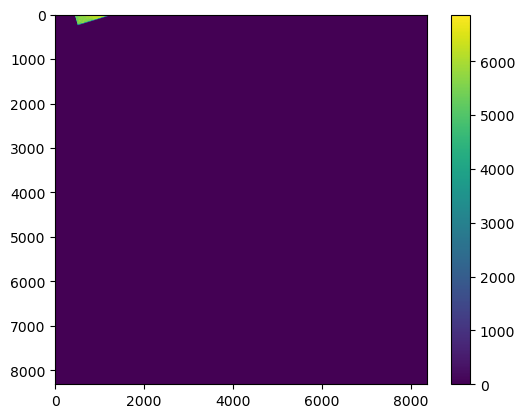

20201116_201452_1034_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4882, 8862)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201116_201452_1034_3B_AnalyticMS_SR_clip_5m.tif
20201116_201452_1034_3B_AnalyticMS_SR_clip.tif resampled
0.0 43518.40819027671


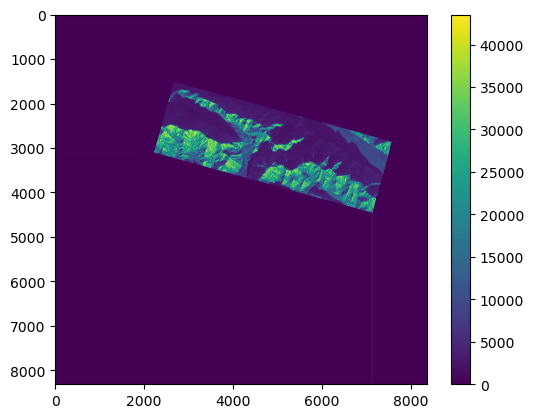

20201104_203721_07_2307_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4027, 12032)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201104_203721_07_2307_3B_AnalyticMS_SR_clip_5m.tif
20201104_203721_07_2307_3B_AnalyticMS_SR_clip.tif resampled
0.0 28103.085026683915


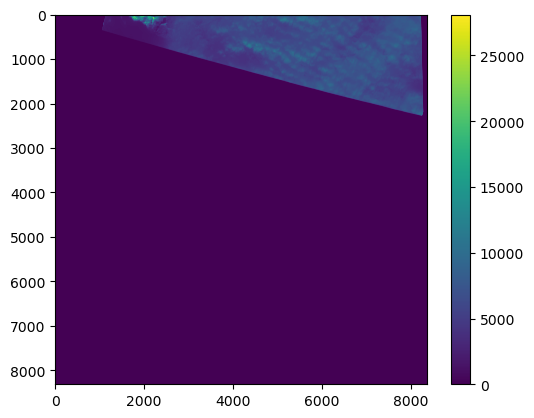

20201113_201325_101b_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (2988, 920)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201113_201325_101b_3B_AnalyticMS_SR_clip_5m.tif
20201113_201325_101b_3B_AnalyticMS_SR_clip.tif resampled
0.0 13641.728872989912


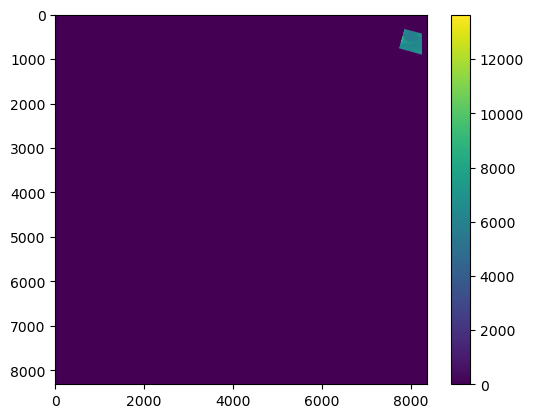

20201116_201911_1040_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (5109, 2985)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201116_201911_1040_3B_AnalyticMS_SR_clip_5m.tif
20201116_201911_1040_3B_AnalyticMS_SR_clip.tif resampled
0.0 43799.369810369084


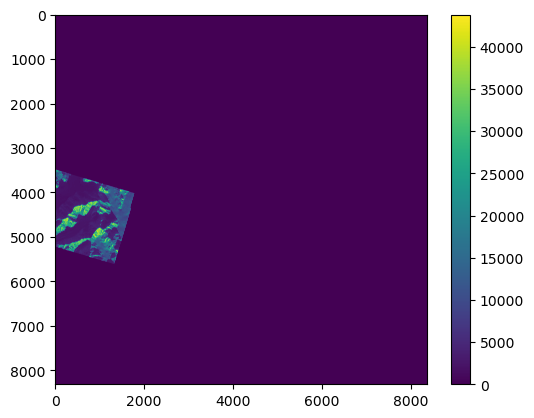

20201120_204430_72_105e_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (1479, 3183)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201120_204430_72_105e_3B_AnalyticMS_SR_clip_5m.tif
20201120_204430_72_105e_3B_AnalyticMS_SR_clip.tif resampled
0.0 30297.46754807958


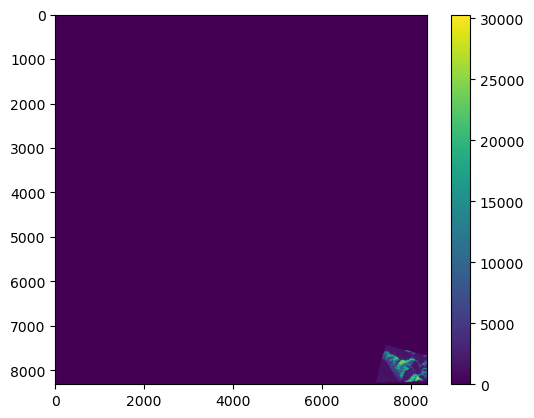

20201112_201755_1034_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (3983, 8380)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201112_201755_1034_3B_AnalyticMS_SR_clip_5m.tif
20201112_201755_1034_3B_AnalyticMS_SR_clip.tif resampled
0.0 13977.615512924172


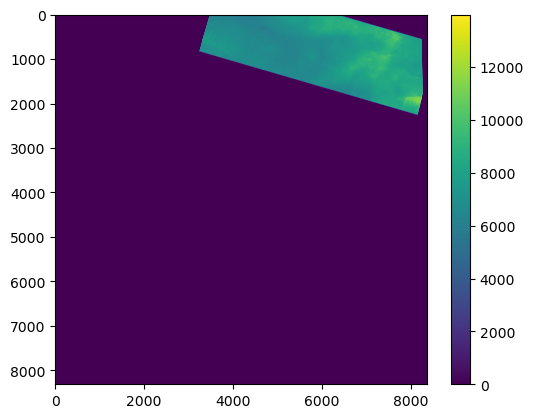

20201114_204527_35_2408_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4608, 5526)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201114_204527_35_2408_3B_AnalyticMS_SR_clip_5m.tif
20201114_204527_35_2408_3B_AnalyticMS_SR_clip.tif resampled
0.0 17177.520004822887


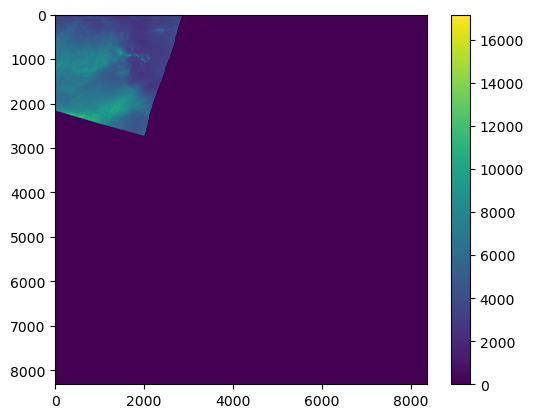

20201120_204428_71_105e_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (6070, 1960)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201120_204428_71_105e_3B_AnalyticMS_SR_clip_5m.tif
20201120_204428_71_105e_3B_AnalyticMS_SR_clip.tif resampled
0.0 30534.69282870688


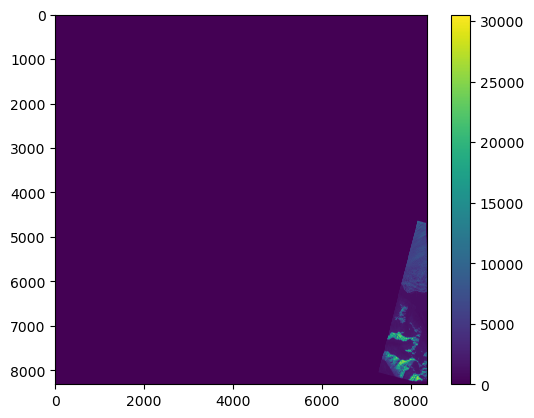

20201116_201606_1002_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4999, 8903)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201116_201606_1002_3B_AnalyticMS_SR_clip_5m.tif
20201116_201606_1002_3B_AnalyticMS_SR_clip.tif resampled
0.0 35607.3604781581


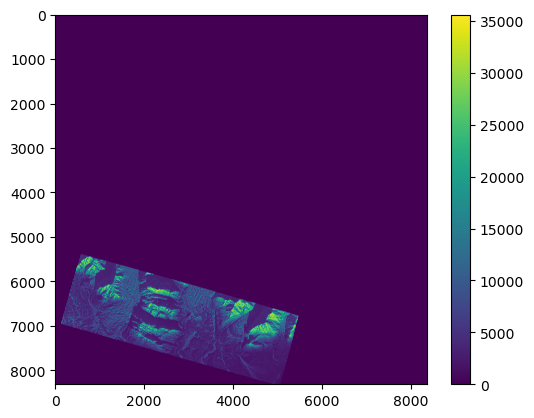

20201115_203819_08_2307_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (8444, 9079)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201115_203819_08_2307_3B_AnalyticMS_SR_clip_5m.tif
20201115_203819_08_2307_3B_AnalyticMS_SR_clip.tif resampled
0.0 44717.43934279795


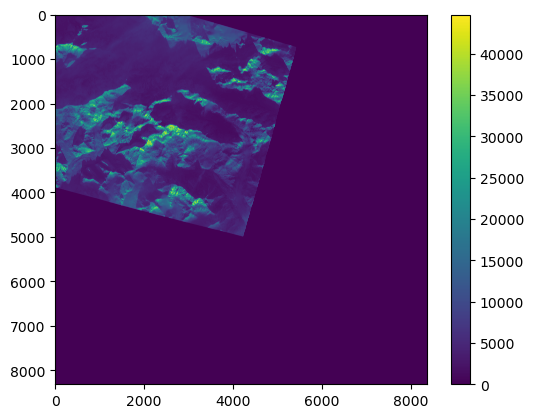

20201104_203538_73_227a_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (7412, 1573)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201104_203538_73_227a_3B_AnalyticMS_SR_clip_5m.tif
20201104_203538_73_227a_3B_AnalyticMS_SR_clip.tif resampled
0.0 11572.163609704978


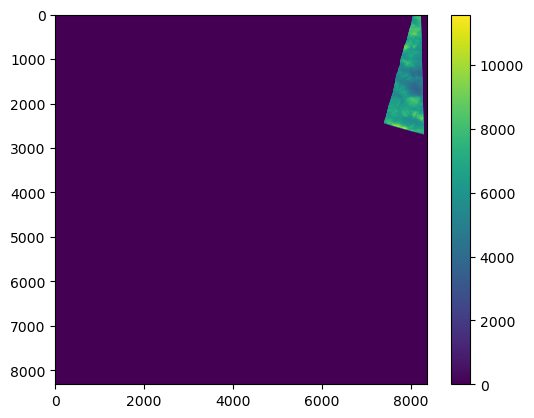

20201113_202034_1026_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (3881, 8252)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201113_202034_1026_3B_AnalyticMS_SR_clip_5m.tif
20201113_202034_1026_3B_AnalyticMS_SR_clip.tif resampled
0.0 32349.611367932044


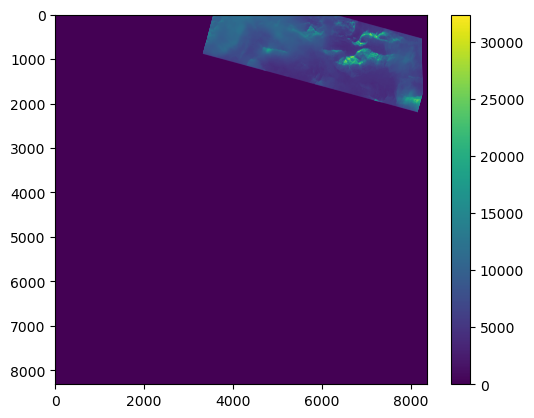

20201105_201556_1035_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4916, 8872)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201105_201556_1035_3B_AnalyticMS_SR_clip_5m.tif
20201105_201556_1035_3B_AnalyticMS_SR_clip.tif resampled
0.0 38398.353422763976


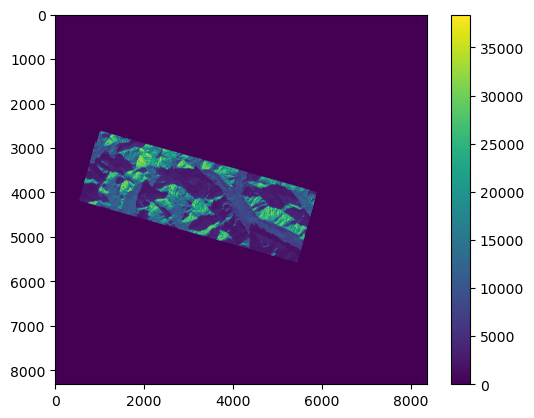

20201115_204653_76_1060_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (1824, 10031)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201115_204653_76_1060_3B_AnalyticMS_SR_clip_5m.tif
20201115_204653_76_1060_3B_AnalyticMS_SR_clip.tif resampled
0.0 37467.61451975104


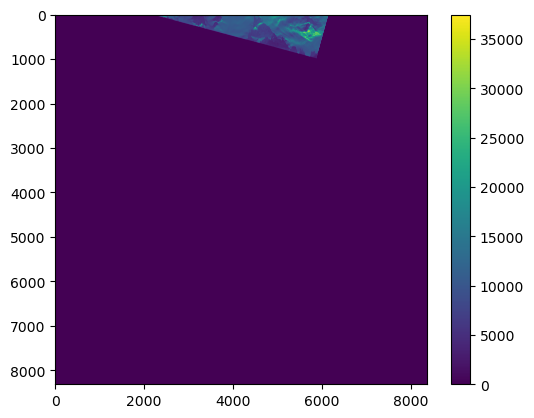

20201102_201459_0f15_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (5000, 2320)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201102_201459_0f15_3B_AnalyticMS_SR_clip_5m.tif
20201102_201459_0f15_3B_AnalyticMS_SR_clip.tif resampled
0.0 32450.37871154757


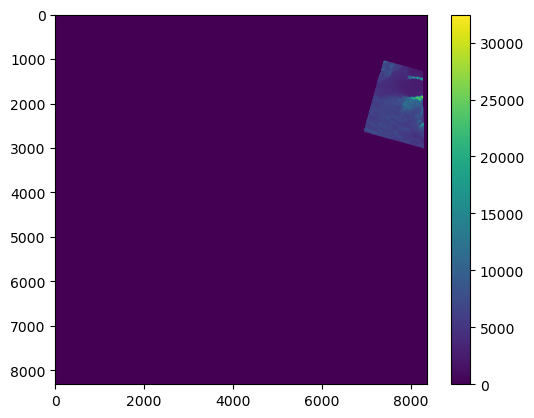

20201109_203800_58_2407_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (7192, 12432)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201109_203800_58_2407_3B_AnalyticMS_SR_clip_5m.tif
20201109_203800_58_2407_3B_AnalyticMS_SR_clip.tif resampled
0.0 32761.44957773815


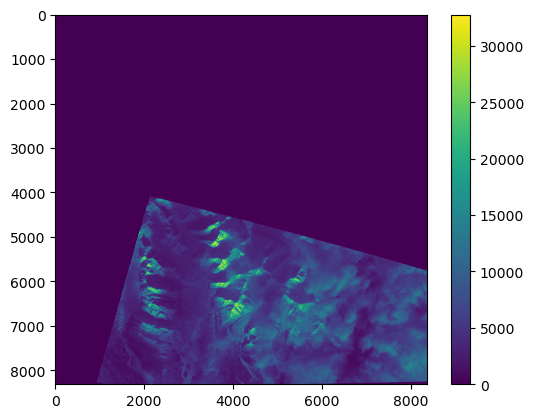

20201110_201452_1032_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (705, 6529)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201110_201452_1032_3B_AnalyticMS_SR_clip_5m.tif
20201110_201452_1032_3B_AnalyticMS_SR_clip.tif resampled
0.0 4137.733337945176


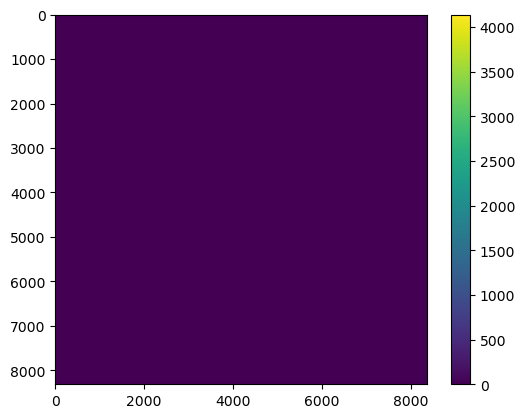

20201113_201326_101b_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4423, 2161)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201113_201326_101b_3B_AnalyticMS_SR_clip_5m.tif
20201113_201326_101b_3B_AnalyticMS_SR_clip.tif resampled
0.0 12965.084392625356


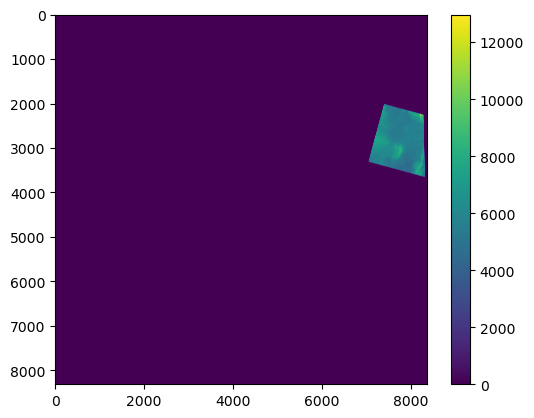

20201107_194757_40_2231_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (5369, 9014)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201107_194757_40_2231_3B_AnalyticMS_SR_clip_5m.tif
20201107_194757_40_2231_3B_AnalyticMS_SR_clip.tif resampled
0.0 18236.493775537772


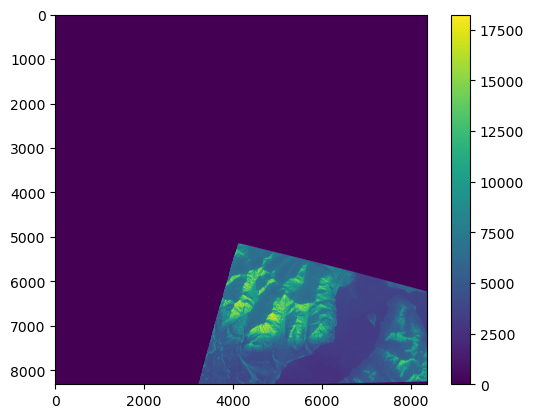

20201104_203543_50_227a_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (6089, 4651)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201104_203543_50_227a_3B_AnalyticMS_SR_clip_5m.tif
20201104_203543_50_227a_3B_AnalyticMS_SR_clip.tif resampled
0.0 11345.058270945965


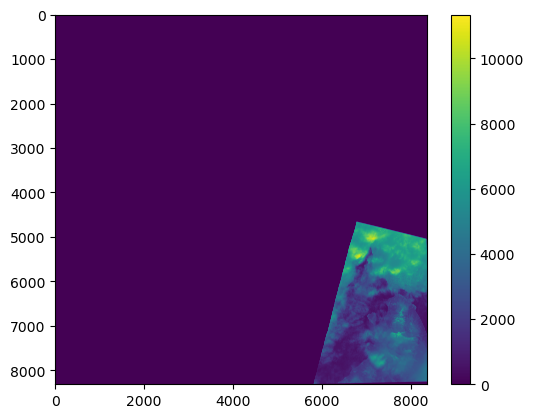

20201116_201451_1034_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4882, 8859)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201116_201451_1034_3B_AnalyticMS_SR_clip_5m.tif
20201116_201451_1034_3B_AnalyticMS_SR_clip.tif resampled
0.0 42848.91165322429


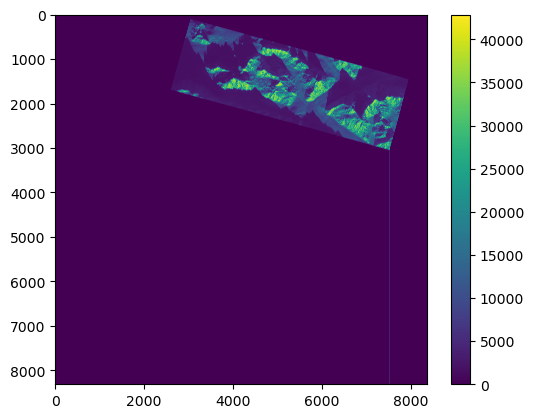

20201114_201459_1038_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4150, 725)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201114_201459_1038_3B_AnalyticMS_SR_clip_5m.tif
20201114_201459_1038_3B_AnalyticMS_SR_clip.tif resampled
0.0 11329.663994185692


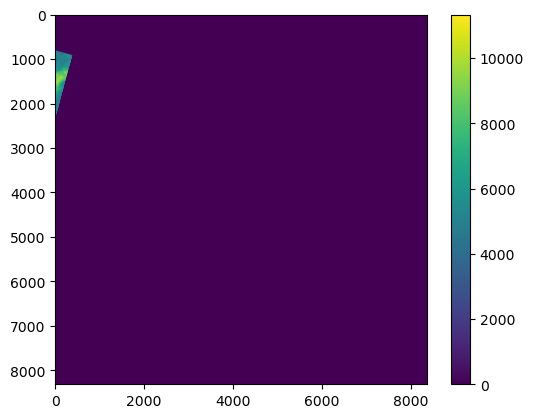

20201114_204153_76_2416_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4535, 13595)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201114_204153_76_2416_3B_AnalyticMS_SR_clip_5m.tif
20201114_204153_76_2416_3B_AnalyticMS_SR_clip.tif resampled
0.0 31359.39626841804


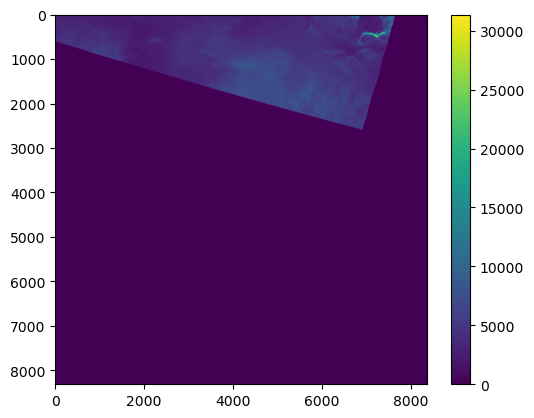

20201101_191528_26_106c_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4019, 9687)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201101_191528_26_106c_3B_AnalyticMS_SR_clip_5m.tif
20201101_191528_26_106c_3B_AnalyticMS_SR_clip.tif resampled
0.0 13561.813145915594


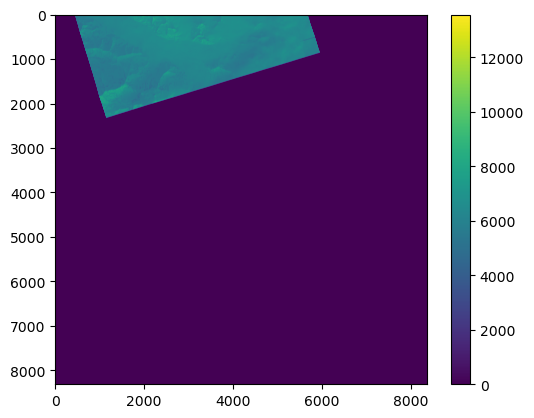

20201110_201454_1032_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4990, 7939)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201110_201454_1032_3B_AnalyticMS_SR_clip_5m.tif
20201110_201454_1032_3B_AnalyticMS_SR_clip.tif resampled
0.0 39062.28743386426


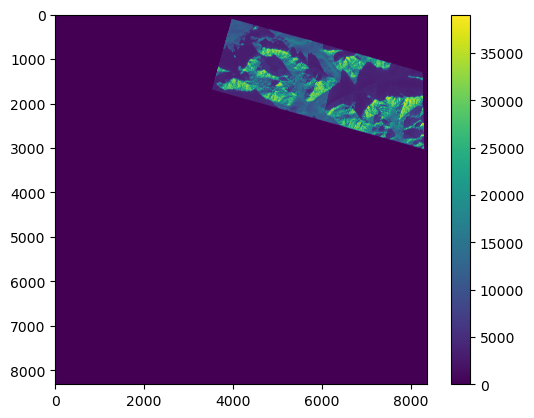

20201104_195156_06_2304_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (6426, 4915)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201104_195156_06_2304_3B_AnalyticMS_SR_clip_5m.tif
20201104_195156_06_2304_3B_AnalyticMS_SR_clip.tif resampled
0.0 39585.3601118251


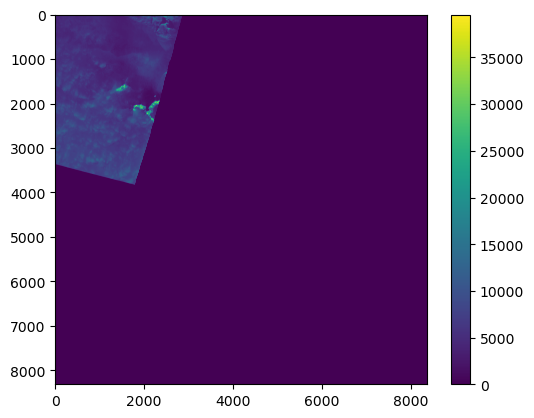

20201120_201755_1013_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (2731, 8922)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201120_201755_1013_3B_AnalyticMS_SR_clip_5m.tif
20201120_201755_1013_3B_AnalyticMS_SR_clip.tif resampled
0.0 40807.25867205112


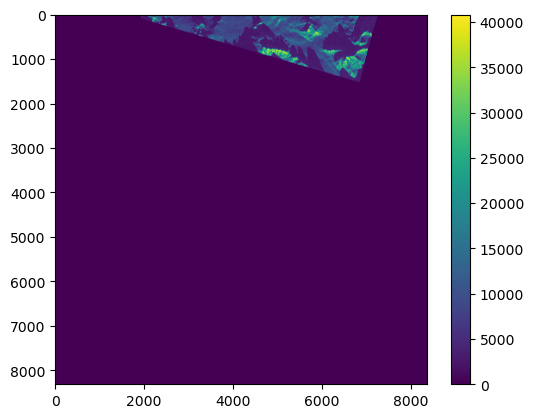

20201115_204655_76_1060_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (6398, 10043)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201115_204655_76_1060_3B_AnalyticMS_SR_clip_5m.tif
20201115_204655_76_1060_3B_AnalyticMS_SR_clip.tif resampled
0.0 41841.63117040505


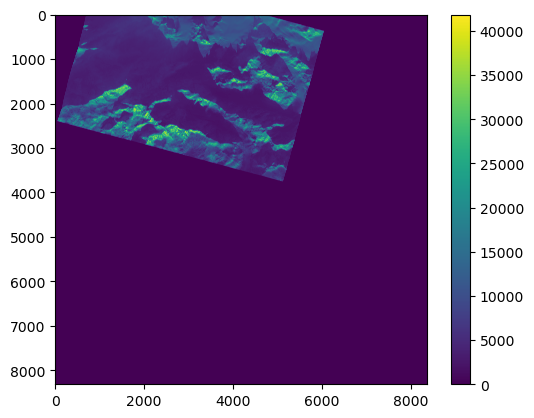

20201102_201030_1014_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4917, 8002)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201102_201030_1014_3B_AnalyticMS_SR_clip_5m.tif
20201102_201030_1014_3B_AnalyticMS_SR_clip.tif resampled
0.0 32948.489944476074


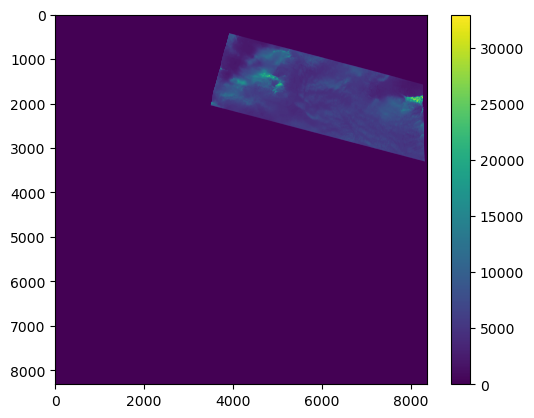

20201102_201029_1014_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (3472, 7348)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201102_201029_1014_3B_AnalyticMS_SR_clip_5m.tif
20201102_201029_1014_3B_AnalyticMS_SR_clip.tif resampled
0.0 28937.14053343518


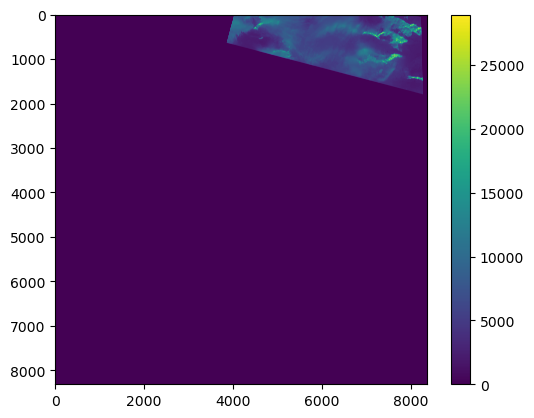

20201117_201551_0f34_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4461, 4421)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201117_201551_0f34_3B_AnalyticMS_SR_clip_5m.tif
20201117_201551_0f34_3B_AnalyticMS_SR_clip.tif resampled
0.0 37136.736997316206


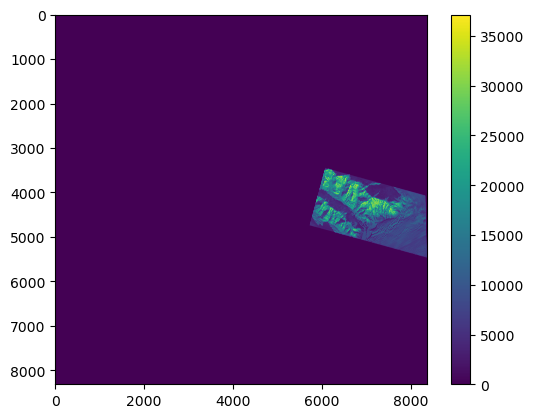

20201114_203921_44_225b_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (10466, 7131)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201114_203921_44_225b_3B_AnalyticMS_SR_clip_5m.tif
20201114_203921_44_225b_3B_AnalyticMS_SR_clip.tif resampled
0.0 17627.786385155487


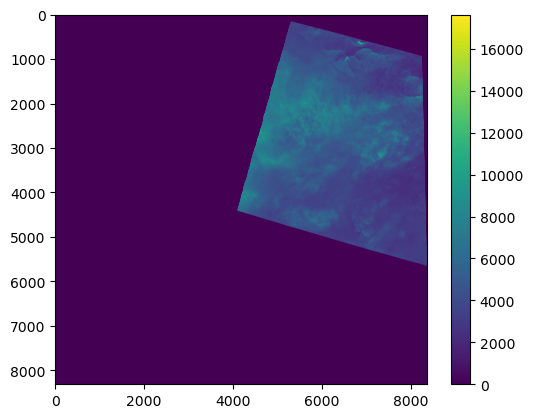

20201109_201625_101b_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4513, 1630)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201109_201625_101b_3B_AnalyticMS_SR_clip_5m.tif
20201109_201625_101b_3B_AnalyticMS_SR_clip.tif resampled
0.0 19667.18549659695


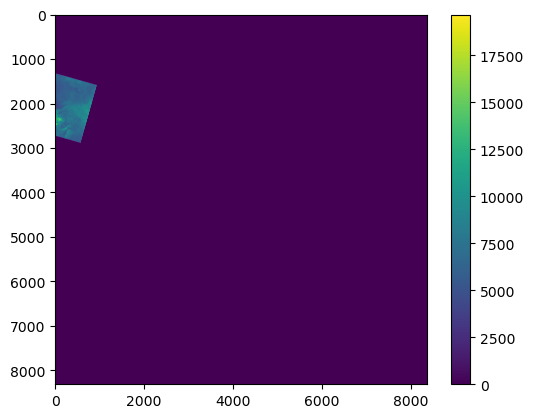

20201106_204444_74_105e_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4352, 3048)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201106_204444_74_105e_3B_AnalyticMS_SR_clip_5m.tif
20201106_204444_74_105e_3B_AnalyticMS_SR_clip.tif resampled
0.0 29977.035697896343


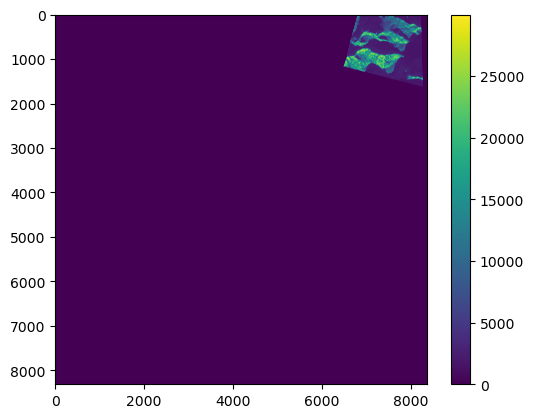

20201106_205305_69_1066_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (2779, 7867)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201106_205305_69_1066_3B_AnalyticMS_SR_clip_5m.tif
20201106_205305_69_1066_3B_AnalyticMS_SR_clip.tif resampled
0.0 29985.796993879532


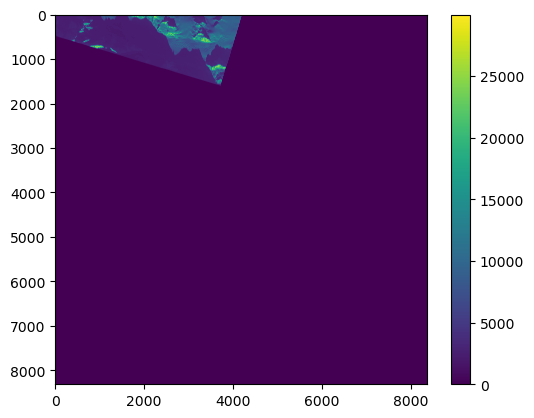

20201120_201759_1013_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4984, 8916)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201120_201759_1013_3B_AnalyticMS_SR_clip_5m.tif
20201120_201759_1013_3B_AnalyticMS_SR_clip.tif resampled
0.0 38863.362614471946


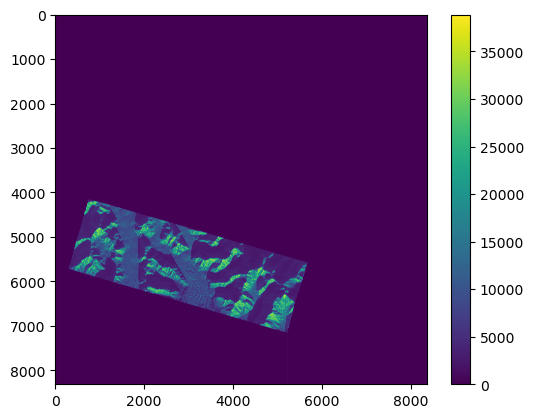

20201101_201557_0f28_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (2626, 1986)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201101_201557_0f28_3B_AnalyticMS_SR_clip_5m.tif
20201101_201557_0f28_3B_AnalyticMS_SR_clip.tif resampled
0.0 5279.34883425871


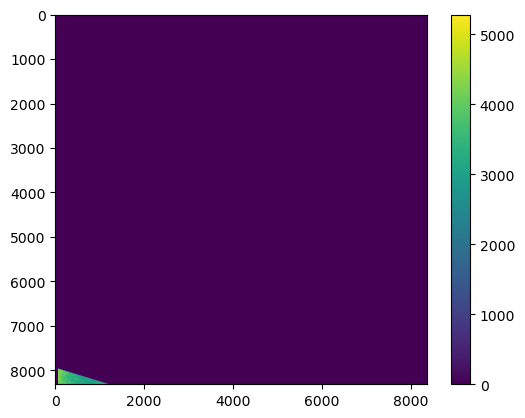

20201107_201156_101f_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4930, 6319)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201107_201156_101f_3B_AnalyticMS_SR_clip_5m.tif
20201107_201156_101f_3B_AnalyticMS_SR_clip.tif resampled
0.0 30370.76352310369


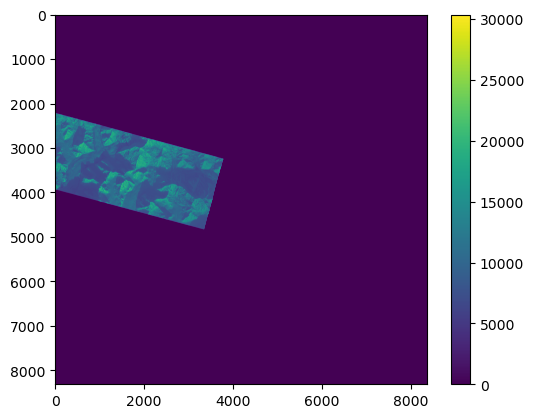

20201101_201045_1004_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4717, 1825)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201101_201045_1004_3B_AnalyticMS_SR_clip_5m.tif
20201101_201045_1004_3B_AnalyticMS_SR_clip.tif resampled
0.0 8717.972683919605


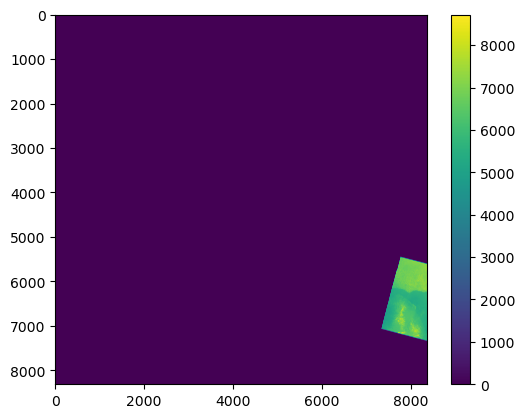

20201110_201458_1032_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4570, 8963)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201110_201458_1032_3B_AnalyticMS_SR_clip_5m.tif
20201110_201458_1032_3B_AnalyticMS_SR_clip.tif resampled
0.0 38116.12302538312


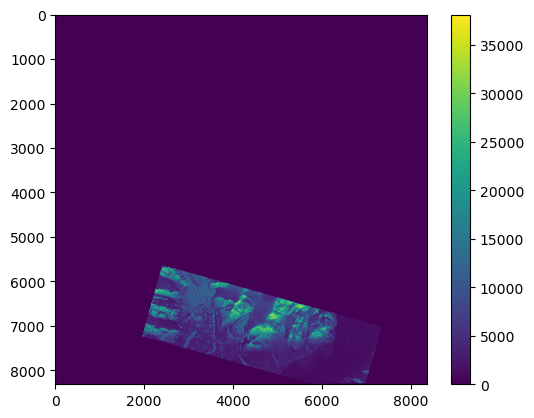

20201114_203919_06_225b_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (5495, 5482)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201114_203919_06_225b_3B_AnalyticMS_SR_clip_5m.tif
20201114_203919_06_225b_3B_AnalyticMS_SR_clip.tif resampled
0.0 30511.771596878985


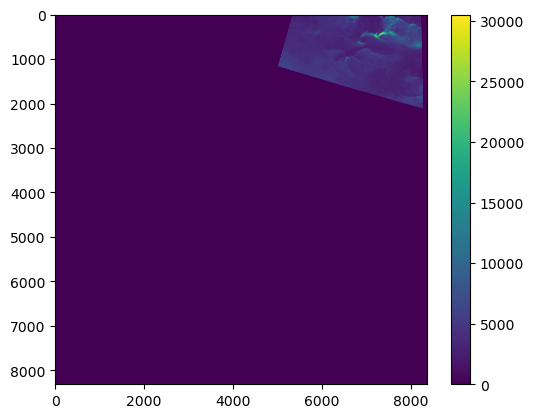

20201115_203628_81_227a_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (10367, 7686)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201115_203628_81_227a_3B_AnalyticMS_SR_clip_5m.tif
20201115_203628_81_227a_3B_AnalyticMS_SR_clip.tif resampled
0.0 42290.08976648224


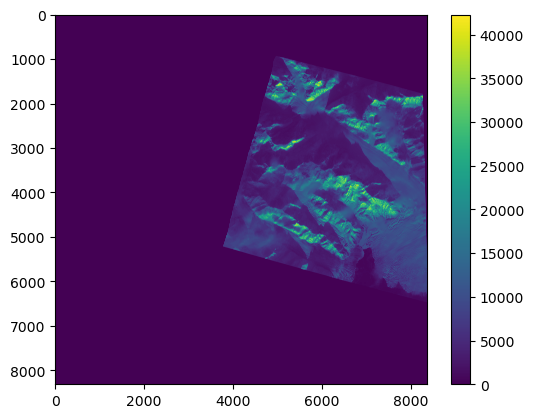

20201105_201553_1035_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (2501, 8902)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201105_201553_1035_3B_AnalyticMS_SR_clip_5m.tif
20201105_201553_1035_3B_AnalyticMS_SR_clip.tif resampled
0.0 37051.78175498383


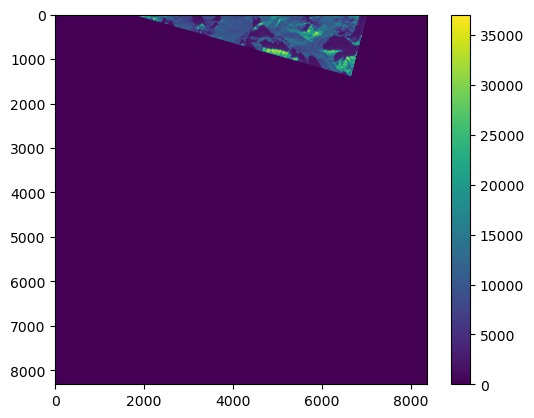

20201107_195903_27_2279_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (10495, 10296)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201107_195903_27_2279_3B_AnalyticMS_SR_clip_5m.tif
20201107_195903_27_2279_3B_AnalyticMS_SR_clip.tif resampled
0.0 21185.663975190066


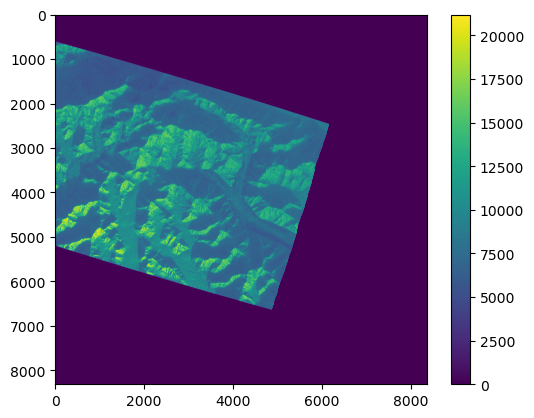

20201105_201555_1035_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4914, 8849)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201105_201555_1035_3B_AnalyticMS_SR_clip_5m.tif
20201105_201555_1035_3B_AnalyticMS_SR_clip.tif resampled
0.0 39771.399238497695


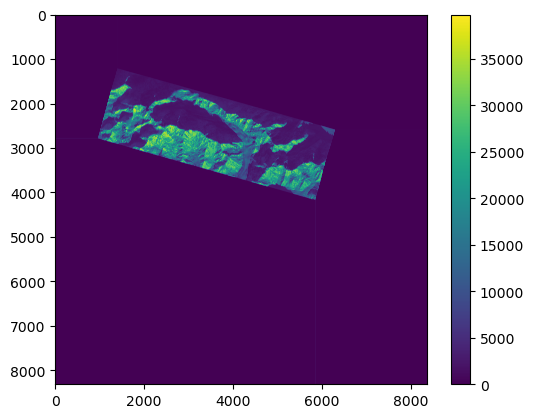

20201106_204446_74_105e_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (7851, 4400)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201106_204446_74_105e_3B_AnalyticMS_SR_clip_5m.tif
20201106_204446_74_105e_3B_AnalyticMS_SR_clip.tif resampled
0.0 32083.07288691774


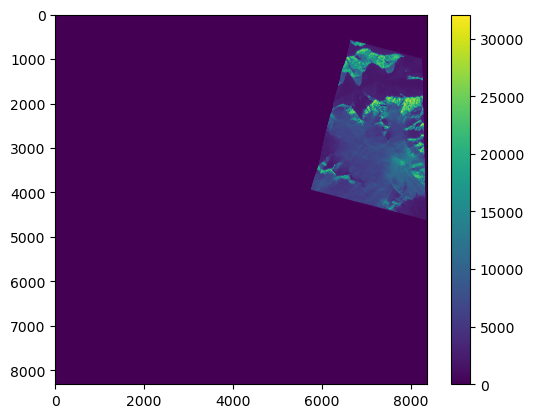

20201106_205307_69_1066_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (7147, 6572)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201106_205307_69_1066_3B_AnalyticMS_SR_clip_5m.tif
20201106_205307_69_1066_3B_AnalyticMS_SR_clip.tif resampled
0.0 32868.46736292142


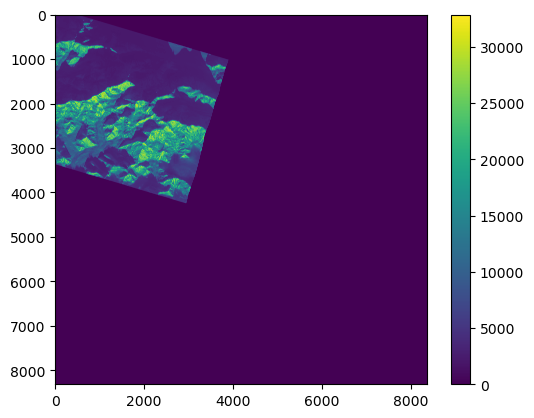

20201105_191424_51_106c_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (5032, 9231)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201105_191424_51_106c_3B_AnalyticMS_SR_clip_5m.tif
20201105_191424_51_106c_3B_AnalyticMS_SR_clip.tif resampled
0.0 38572.89006060039


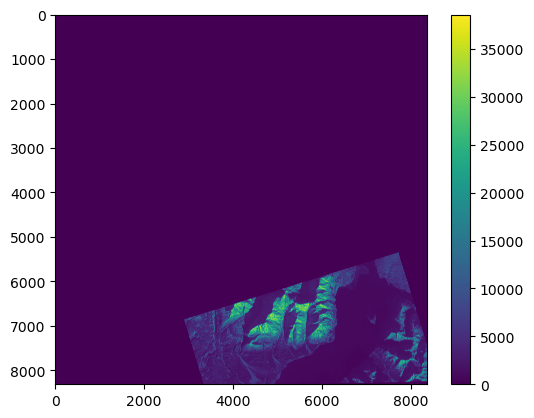

20201115_204657_76_1060_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (7993, 8850)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201115_204657_76_1060_3B_AnalyticMS_SR_clip_5m.tif
20201115_204657_76_1060_3B_AnalyticMS_SR_clip.tif resampled
0.0 41248.81820574442


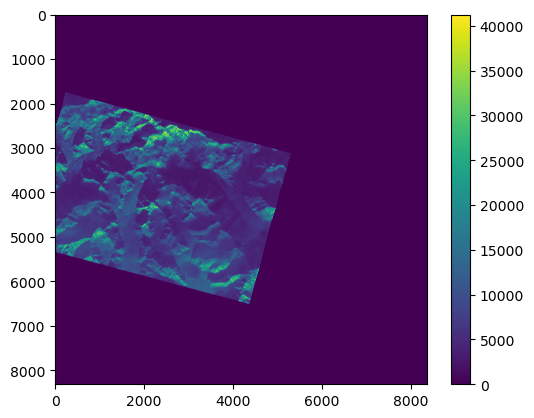

20201116_201605_1002_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4919, 8888)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201116_201605_1002_3B_AnalyticMS_SR_clip_5m.tif
20201116_201605_1002_3B_AnalyticMS_SR_clip.tif resampled
0.0 36358.07370793978


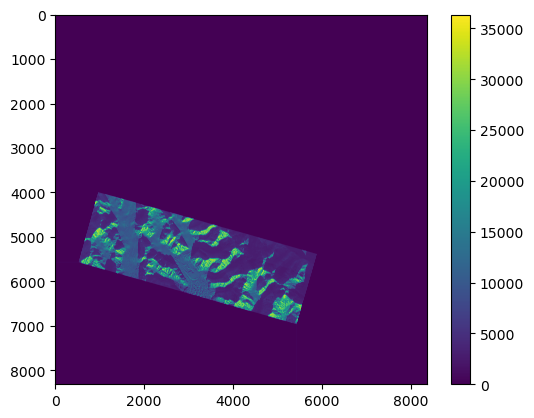

20201104_195153_84_2304_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (1380, 6332)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201104_195153_84_2304_3B_AnalyticMS_SR_clip_5m.tif
20201104_195153_84_2304_3B_AnalyticMS_SR_clip.tif resampled
0.0 22959.98907126962


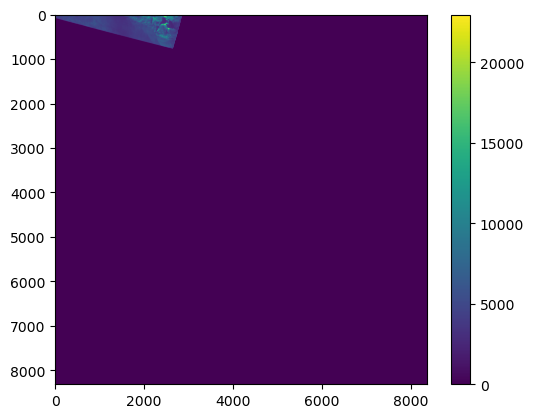

20201116_201914_1040_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (2849, 956)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201116_201914_1040_3B_AnalyticMS_SR_clip_5m.tif
20201116_201914_1040_3B_AnalyticMS_SR_clip.tif resampled
0.0 25153.915183561974


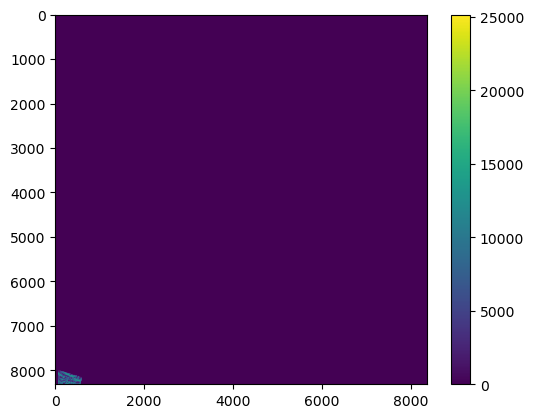

20201107_195907_78_2279_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (3170, 7107)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201107_195907_78_2279_3B_AnalyticMS_SR_clip_5m.tif
20201107_195907_78_2279_3B_AnalyticMS_SR_clip.tif resampled
0.0 16879.44948821387


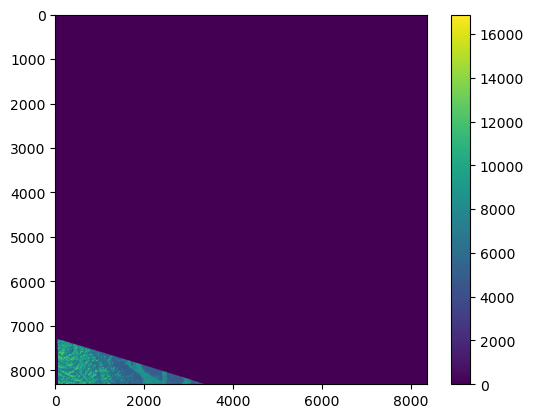

20201115_203821_45_2307_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (10480, 7530)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201115_203821_45_2307_3B_AnalyticMS_SR_clip_5m.tif
20201115_203821_45_2307_3B_AnalyticMS_SR_clip.tif resampled
0.0 44498.054637501205


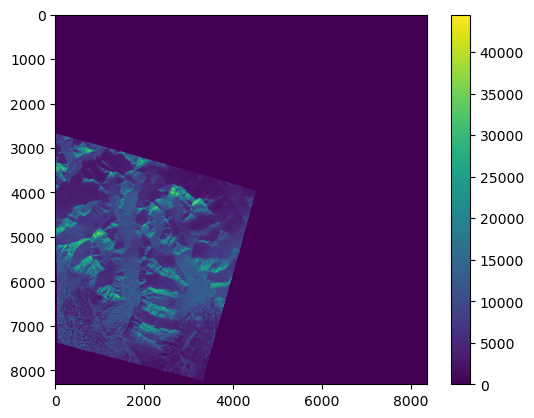

20201116_201603_1002_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4914, 8888)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201116_201603_1002_3B_AnalyticMS_SR_clip_5m.tif
20201116_201603_1002_3B_AnalyticMS_SR_clip.tif resampled
0.0 39953.97583108169


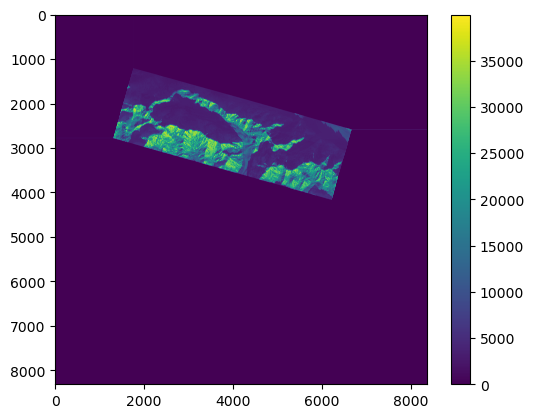

20201110_204205_18_241c_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (3550, 1284)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201110_204205_18_241c_3B_AnalyticMS_SR_clip_5m.tif
20201110_204205_18_241c_3B_AnalyticMS_SR_clip.tif resampled
0.0 4142.610765247895


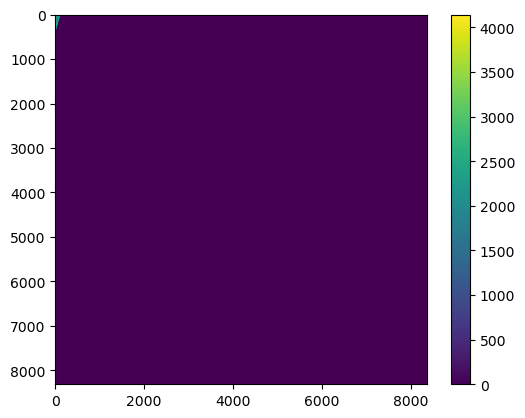

20201107_195858_75_2279_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (1048, 13380)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201107_195858_75_2279_3B_AnalyticMS_SR_clip_5m.tif
20201107_195858_75_2279_3B_AnalyticMS_SR_clip.tif resampled
0.0 14425.443264381303


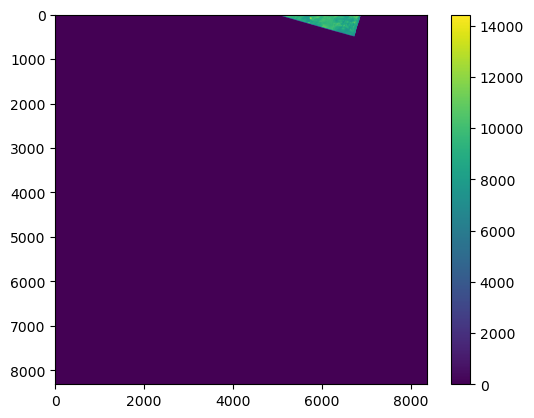

20201115_203626_43_227a_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (6653, 6075)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201115_203626_43_227a_3B_AnalyticMS_SR_clip_5m.tif
20201115_203626_43_227a_3B_AnalyticMS_SR_clip.tif resampled
0.0 41060.40381319129


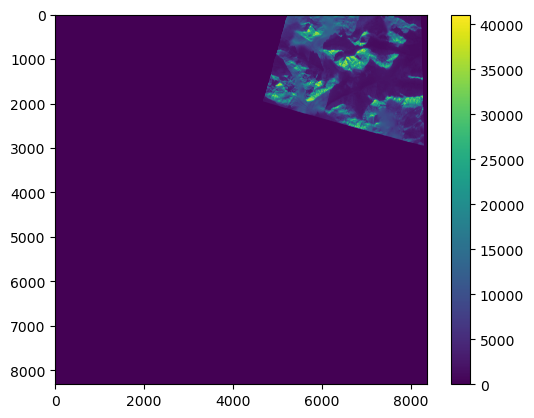

20201102_204737_68_1064_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (2176, 8664)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201102_204737_68_1064_3B_AnalyticMS_SR_clip_5m.tif
20201102_204737_68_1064_3B_AnalyticMS_SR_clip.tif resampled
0.0 28800.948270941026


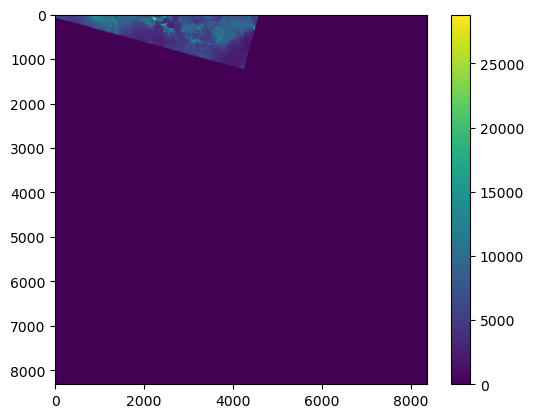

20201104_195200_50_2304_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (7208, 1756)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201104_195200_50_2304_3B_AnalyticMS_SR_clip_5m.tif
20201104_195200_50_2304_3B_AnalyticMS_SR_clip.tif resampled
0.0 12793.010457779226


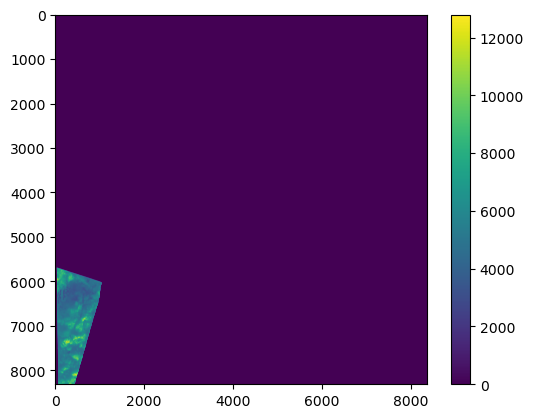

20201116_201912_1040_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (5126, 2311)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201116_201912_1040_3B_AnalyticMS_SR_clip_5m.tif
20201116_201912_1040_3B_AnalyticMS_SR_clip.tif resampled
0.0 40803.88575007807


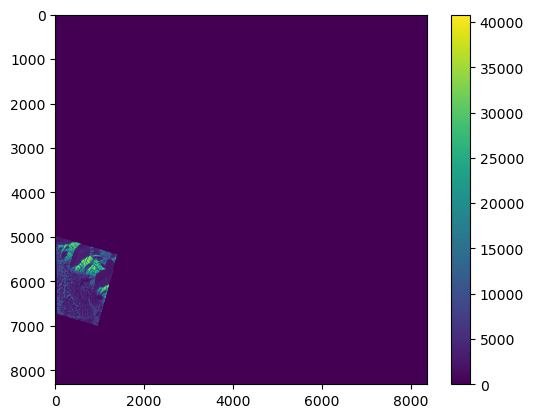

20201109_203756_01_2407_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (6712, 9311)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201109_203756_01_2407_3B_AnalyticMS_SR_clip_5m.tif
20201109_203756_01_2407_3B_AnalyticMS_SR_clip.tif resampled
0.0 34126.237973773445


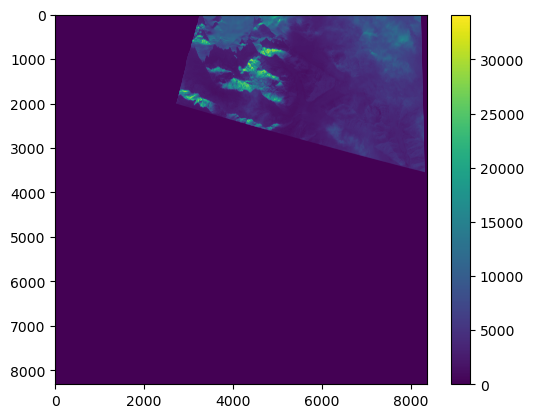

20201105_201559_1035_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (2687, 7708)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201105_201559_1035_3B_AnalyticMS_SR_clip_5m.tif
20201105_201559_1035_3B_AnalyticMS_SR_clip.tif resampled
0.0 27535.212691891837


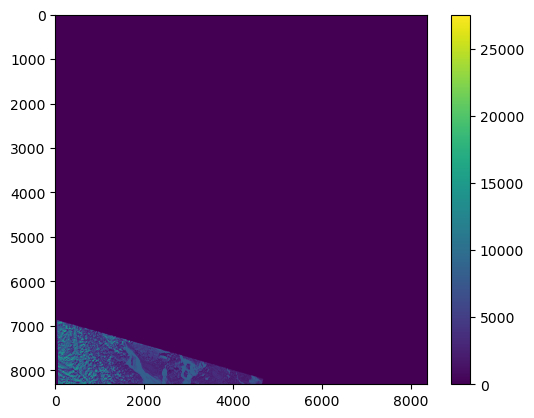

20201110_201455_1032_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (5000, 8650)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201110_201455_1032_3B_AnalyticMS_SR_clip_5m.tif
20201110_201455_1032_3B_AnalyticMS_SR_clip.tif resampled
0.0 39124.759100182644


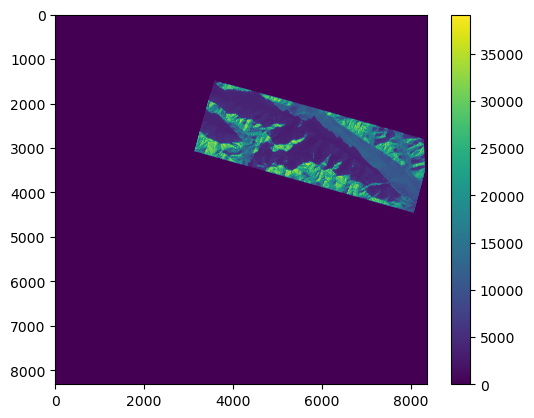

20201101_195423_92_2271_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (3324, 7029)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201101_195423_92_2271_3B_AnalyticMS_SR_clip_5m.tif
20201101_195423_92_2271_3B_AnalyticMS_SR_clip.tif resampled
0.0 8385.41643926672


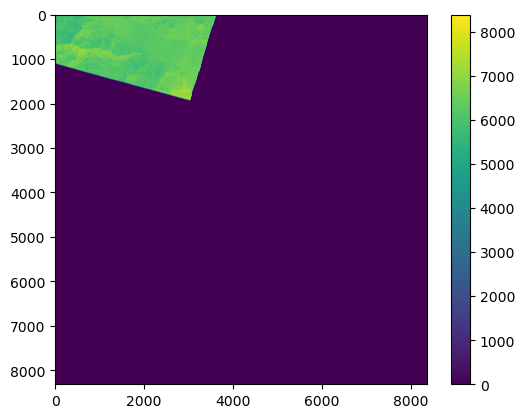

20201114_201458_1038_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (1826, 1379)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201114_201458_1038_3B_AnalyticMS_SR_clip_5m.tif
20201114_201458_1038_3B_AnalyticMS_SR_clip.tif resampled
0.0 8185.48704907992


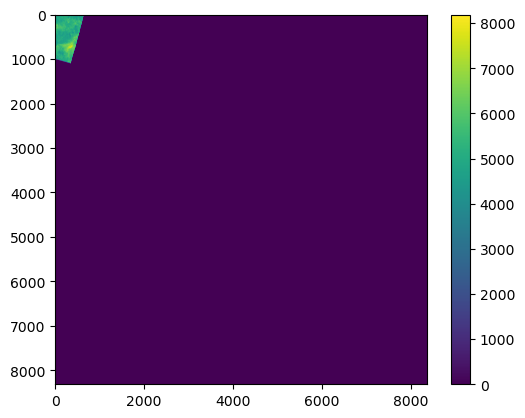

20201120_201754_1013_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (417, 8951)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201120_201754_1013_3B_AnalyticMS_SR_clip_5m.tif
20201120_201754_1013_3B_AnalyticMS_SR_clip.tif resampled
0.0 20271.30099375806


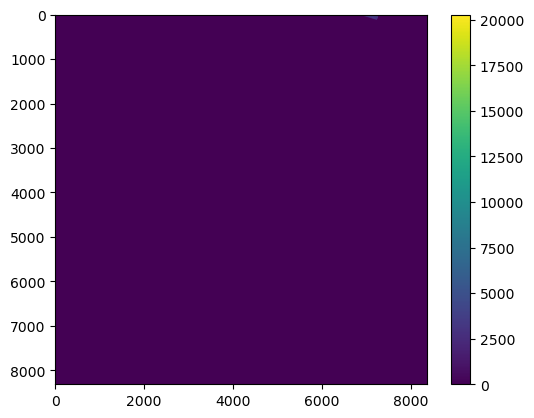

20201116_201456_1034_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (2190, 8928)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201116_201456_1034_3B_AnalyticMS_SR_clip_5m.tif
20201116_201456_1034_3B_AnalyticMS_SR_clip.tif resampled
0.0 26007.7544307162


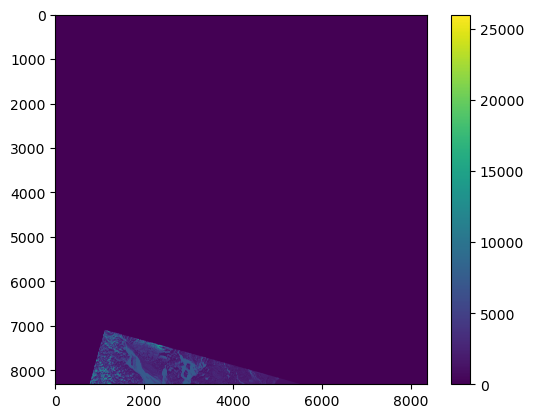

20201113_201327_101b_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4908, 2857)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201113_201327_101b_3B_AnalyticMS_SR_clip_5m.tif
20201113_201327_101b_3B_AnalyticMS_SR_clip.tif resampled
0.0 10838.040112925417


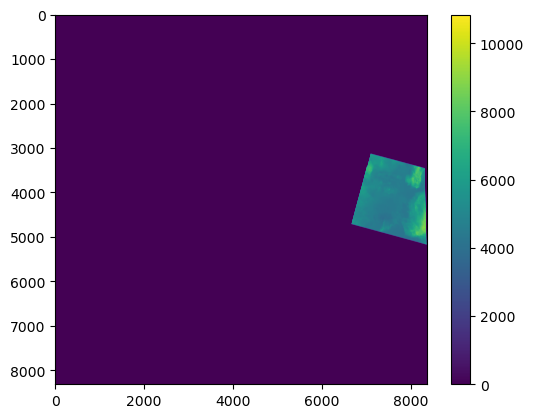

20201106_204448_74_105e_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (7853, 5662)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201106_204448_74_105e_3B_AnalyticMS_SR_clip_5m.tif
20201106_204448_74_105e_3B_AnalyticMS_SR_clip.tif resampled
0.0 29907.007651200405


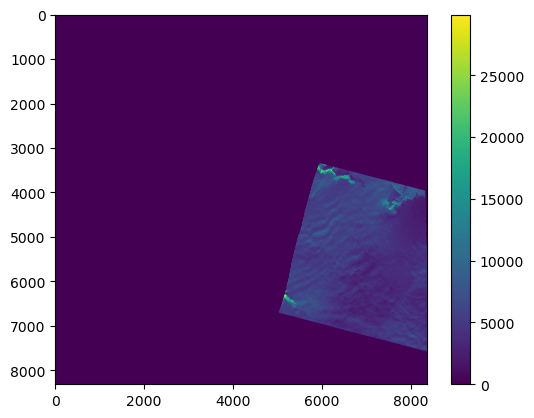

20201110_201453_1032_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (3014, 7234)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201110_201453_1032_3B_AnalyticMS_SR_clip_5m.tif
20201110_201453_1032_3B_AnalyticMS_SR_clip.tif resampled
0.0 39361.20623814344


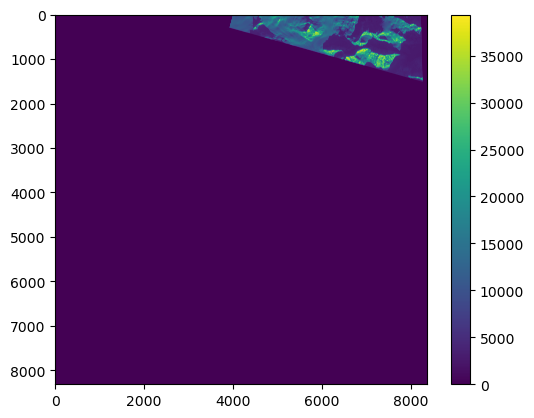

20201106_205309_69_1066_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (7853, 5246)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201106_205309_69_1066_3B_AnalyticMS_SR_clip_5m.tif
20201106_205309_69_1066_3B_AnalyticMS_SR_clip.tif resampled
0.0 32999.641612822765


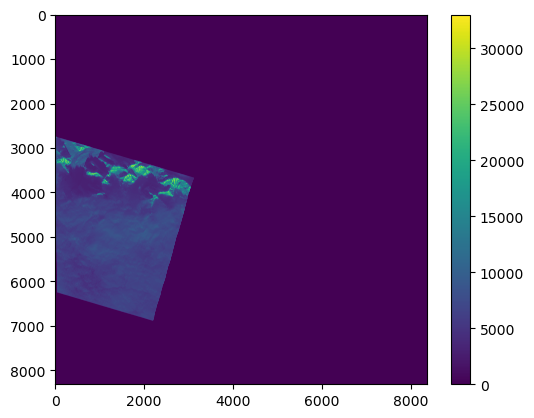

20201116_201450_1034_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (2956, 8774)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201116_201450_1034_3B_AnalyticMS_SR_clip_5m.tif
20201116_201450_1034_3B_AnalyticMS_SR_clip.tif resampled
0.0 42529.589247205244


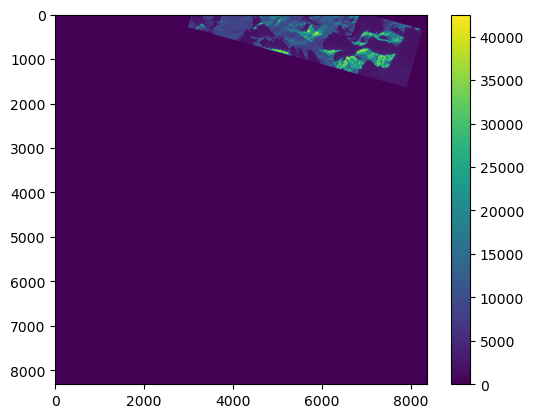

20201104_203545_88_227a_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (716, 6073)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201104_203545_88_227a_3B_AnalyticMS_SR_clip_5m.tif
20201104_203545_88_227a_3B_AnalyticMS_SR_clip.tif resampled
0.0 3973.5764671339907


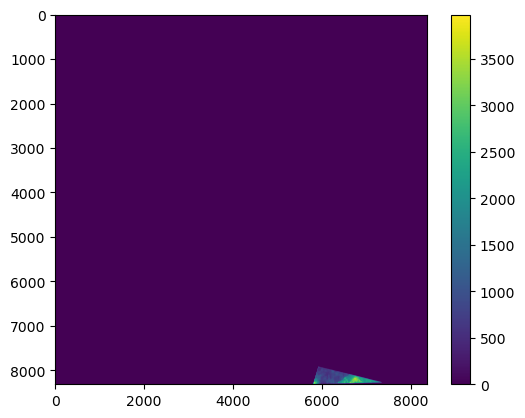

20201101_201556_0f28_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4354, 2535)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201101_201556_0f28_3B_AnalyticMS_SR_clip_5m.tif
20201101_201556_0f28_3B_AnalyticMS_SR_clip.tif resampled
0.0 6767.041495039407


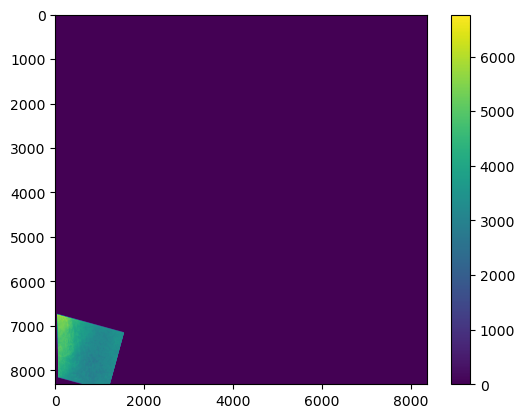

20201107_201157_101f_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4923, 5654)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201107_201157_101f_3B_AnalyticMS_SR_clip_5m.tif
20201107_201157_101f_3B_AnalyticMS_SR_clip.tif resampled
0.0 30086.64203771563


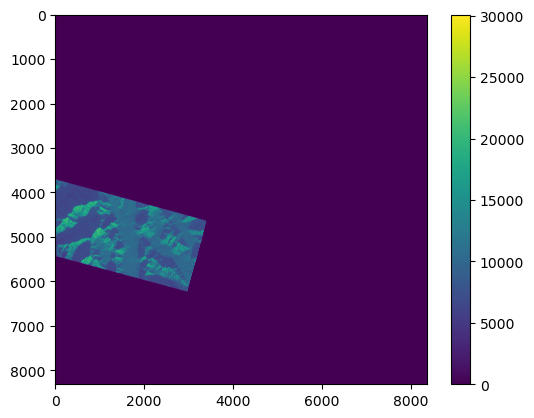

20201101_201044_1004_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4427, 1155)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201101_201044_1004_3B_AnalyticMS_SR_clip_5m.tif
20201101_201044_1004_3B_AnalyticMS_SR_clip.tif resampled
0.0 8993.667112168743


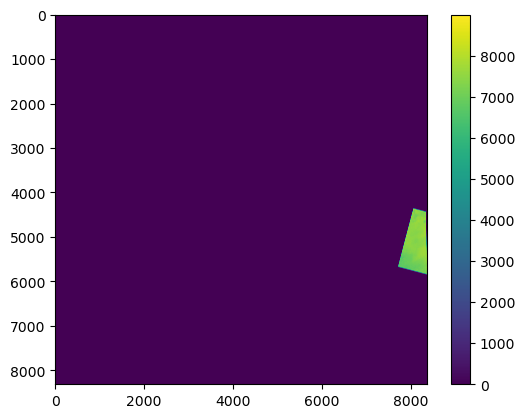

20201104_195158_28_2304_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (9816, 3492)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201104_195158_28_2304_3B_AnalyticMS_SR_clip_5m.tif
20201104_195158_28_2304_3B_AnalyticMS_SR_clip.tif resampled
0.0 13832.886048595145


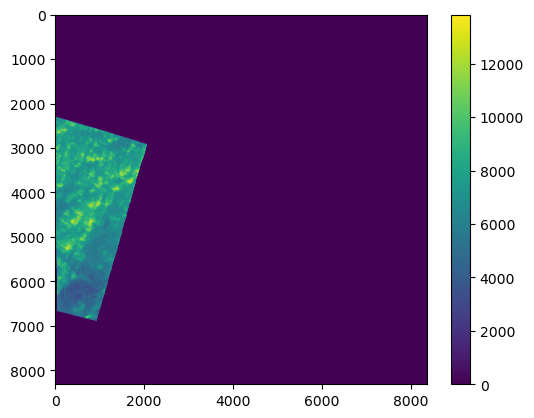

20201115_204659_76_1060_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (6529, 7541)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201115_204659_76_1060_3B_AnalyticMS_SR_clip_5m.tif
20201115_204659_76_1060_3B_AnalyticMS_SR_clip.tif resampled
0.0 37190.013550212134


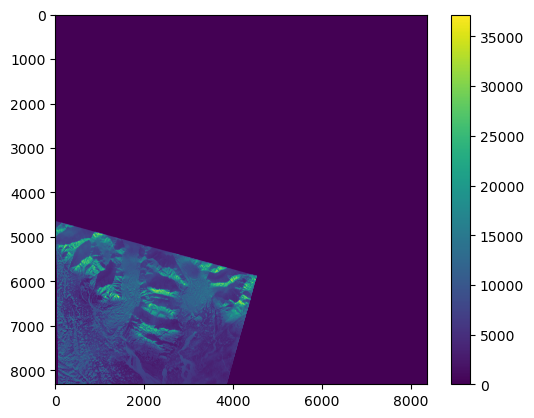

20201103_201031_1009_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (1063, 2711)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201103_201031_1009_3B_AnalyticMS_SR_clip_5m.tif
20201103_201031_1009_3B_AnalyticMS_SR_clip.tif resampled
0.0 11205.456082622957


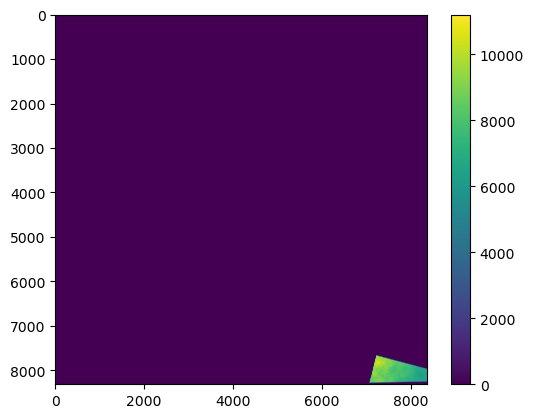

20201120_201758_1013_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4991, 8914)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201120_201758_1013_3B_AnalyticMS_SR_clip_5m.tif
20201120_201758_1013_3B_AnalyticMS_SR_clip.tif resampled
0.0 40133.39816598862


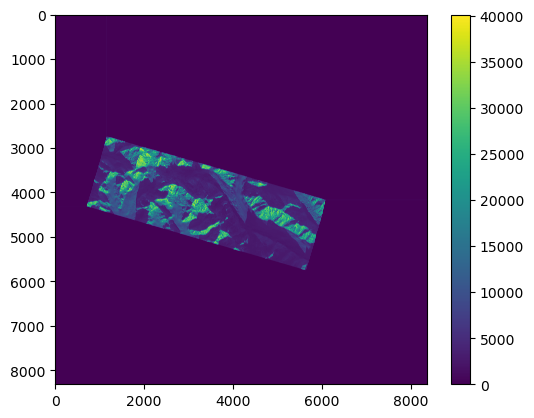

20201110_201459_1032_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (2268, 8945)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201110_201459_1032_3B_AnalyticMS_SR_clip_5m.tif
20201110_201459_1032_3B_AnalyticMS_SR_clip.tif resampled
0.0 25173.843040784275


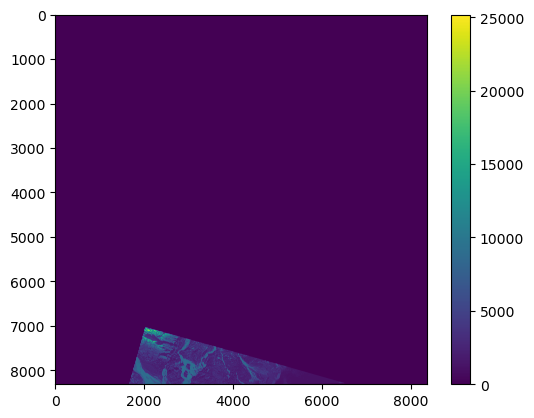

20201106_191913_82_106d_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (7930, 728)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201106_191913_82_106d_3B_AnalyticMS_SR_clip_5m.tif
20201106_191913_82_106d_3B_AnalyticMS_SR_clip.tif resampled
0.0 12699.819200927768


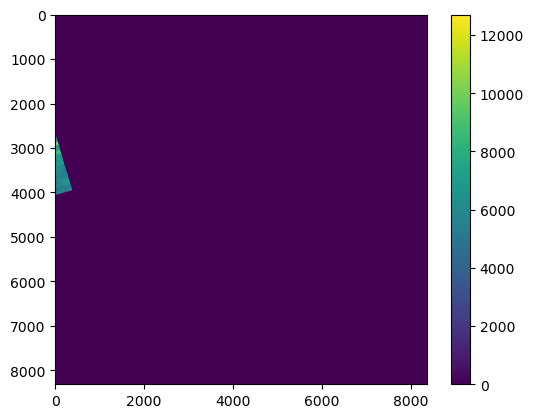

20201102_204739_68_1064_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (6743, 7382)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201102_204739_68_1064_3B_AnalyticMS_SR_clip_5m.tif
20201102_204739_68_1064_3B_AnalyticMS_SR_clip.tif resampled
0.0 33887.929179007704


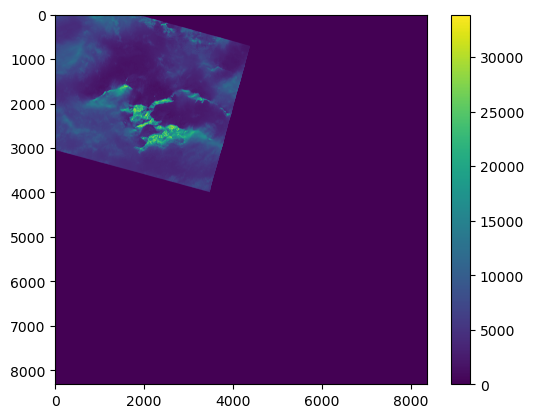

20201102_201028_1014_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (1133, 6659)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201102_201028_1014_3B_AnalyticMS_SR_clip_5m.tif
20201102_201028_1014_3B_AnalyticMS_SR_clip.tif resampled
0.0 25916.908994268357


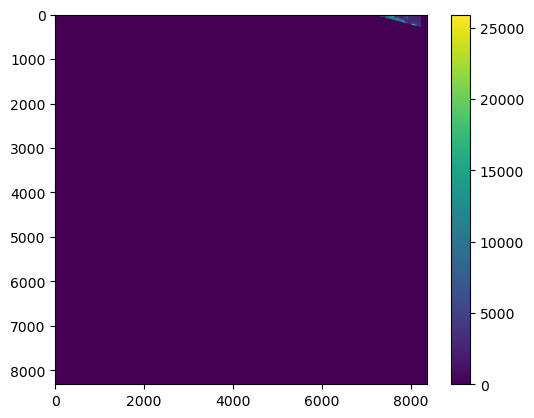

20201107_201200_101f_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (1513, 3702)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201107_201200_101f_3B_AnalyticMS_SR_clip_5m.tif
20201107_201200_101f_3B_AnalyticMS_SR_clip.tif resampled
0.0 12488.329559221704


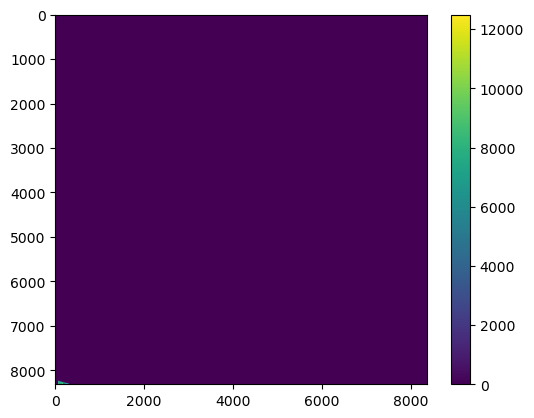

20201105_191429_06_106c_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (6516, 9728)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201105_191429_06_106c_3B_AnalyticMS_SR_clip_5m.tif
20201105_191429_06_106c_3B_AnalyticMS_SR_clip.tif resampled
0.0 40528.66255126878


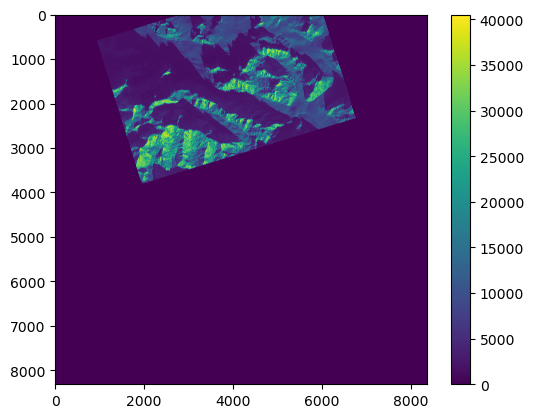

20201113_202036_1026_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4780, 8730)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201113_202036_1026_3B_AnalyticMS_SR_clip_5m.tif
20201113_202036_1026_3B_AnalyticMS_SR_clip.tif resampled
0.0 18091.571778609403


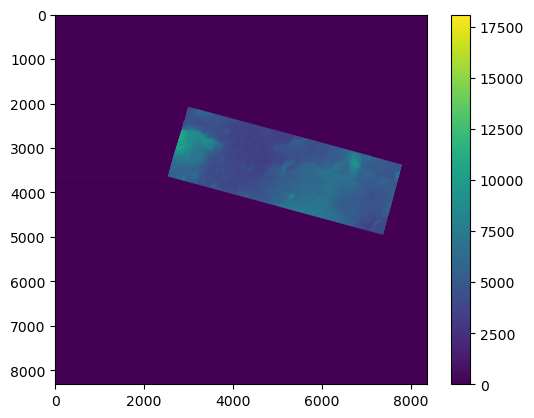

20201105_201554_1035_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4793, 8912)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201105_201554_1035_3B_AnalyticMS_SR_clip_5m.tif
20201105_201554_1035_3B_AnalyticMS_SR_clip.tif resampled
0.0 38195.97538291406


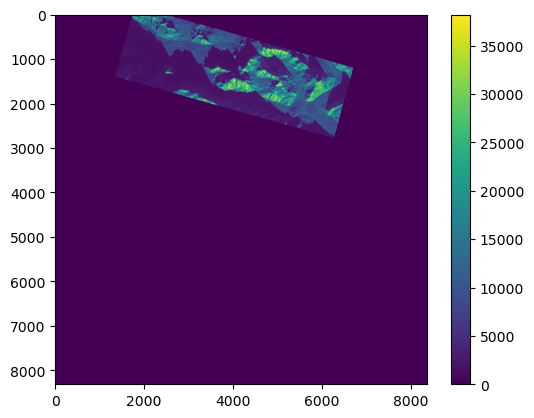

20201105_201552_1035_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (204, 8921)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201105_201552_1035_3B_AnalyticMS_SR_clip_5m.tif
20201105_201552_1035_3B_AnalyticMS_SR_clip.tif resampled
0.0 2030.58199883846


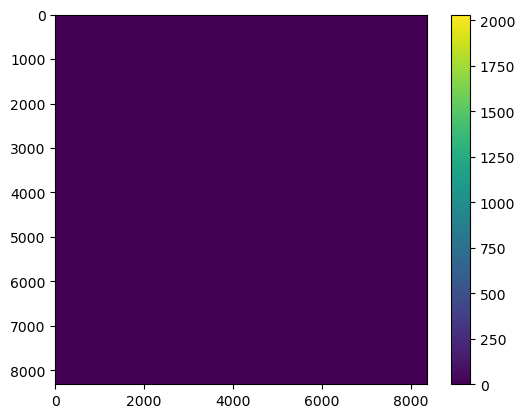

20201109_203758_29_2407_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (10169, 10928)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201109_203758_29_2407_3B_AnalyticMS_SR_clip_5m.tif
20201109_203758_29_2407_3B_AnalyticMS_SR_clip.tif resampled
0.0 35331.5970718612


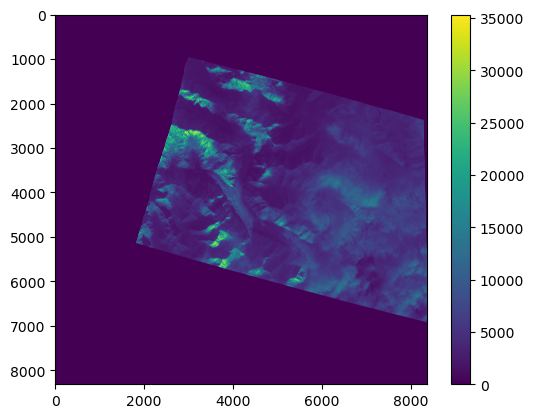

20201116_201608_1002_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (428, 7711)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201116_201608_1002_3B_AnalyticMS_SR_clip_5m.tif
20201116_201608_1002_3B_AnalyticMS_SR_clip.tif resampled
0.0 14840.579922532708


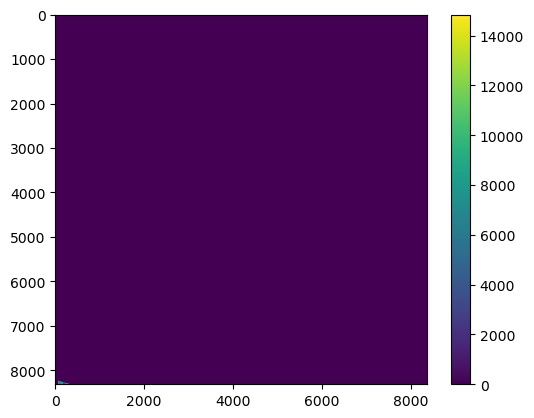

20201109_203802_86_2407_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (2048, 13576)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201109_203802_86_2407_3B_AnalyticMS_SR_clip_5m.tif
20201109_203802_86_2407_3B_AnalyticMS_SR_clip.tif resampled
0.0 10042.3673119791


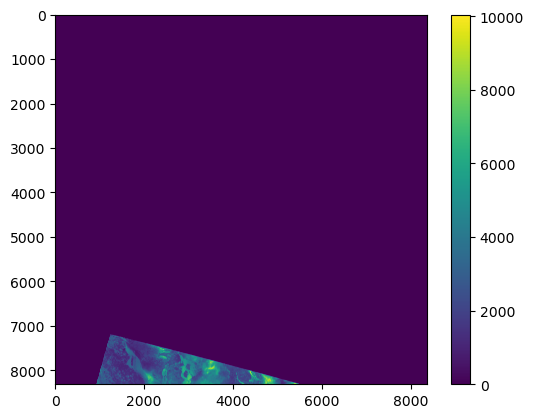

20201116_201602_1002_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4447, 8756)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201116_201602_1002_3B_AnalyticMS_SR_clip_5m.tif
20201116_201602_1002_3B_AnalyticMS_SR_clip.tif resampled
0.0 37613.17139597573


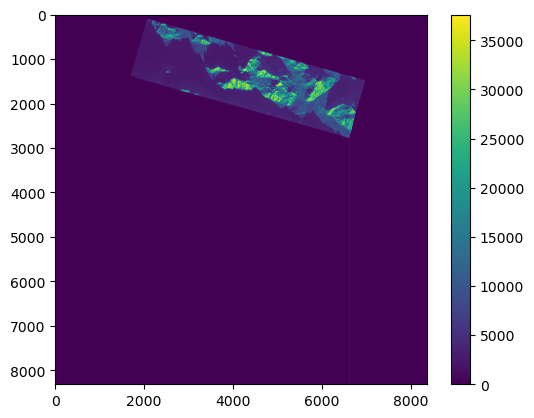

20201104_203725_80_2307_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (9735, 12676)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201104_203725_80_2307_3B_AnalyticMS_SR_clip_5m.tif
20201104_203725_80_2307_3B_AnalyticMS_SR_clip.tif resampled
0.0 20697.11834936477


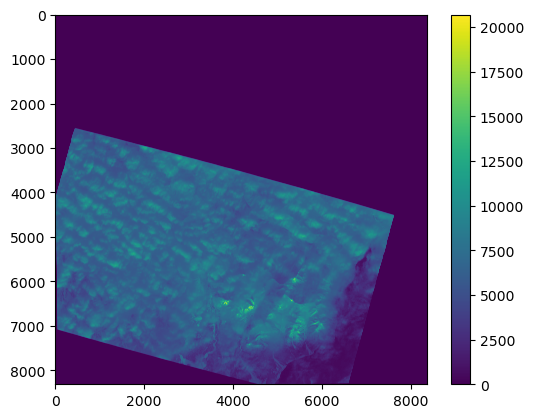

20201105_201558_1035_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4996, 8383)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201105_201558_1035_3B_AnalyticMS_SR_clip_5m.tif
20201105_201558_1035_3B_AnalyticMS_SR_clip.tif resampled
0.0 35979.722818651935


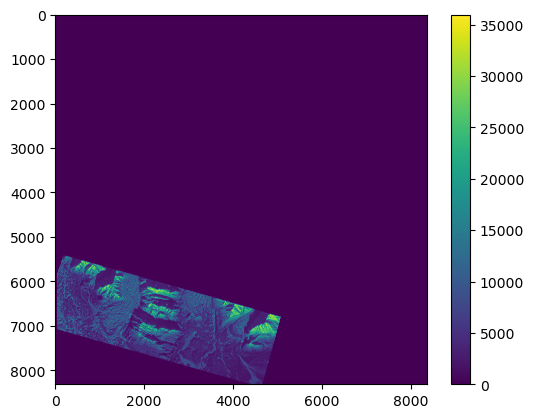

20201116_201913_1040_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (5126, 1660)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201116_201913_1040_3B_AnalyticMS_SR_clip_5m.tif
20201116_201913_1040_3B_AnalyticMS_SR_clip.tif resampled
0.0 26182.05924861914


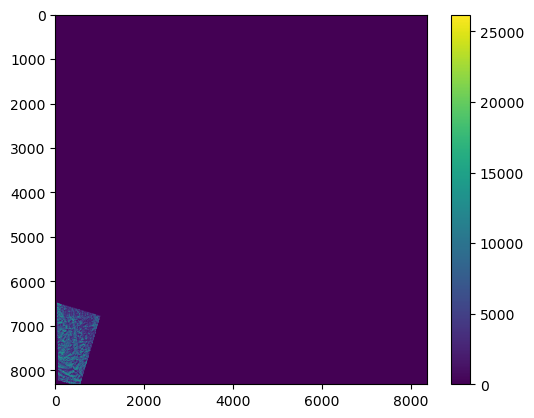

20201116_201604_1002_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (4917, 8886)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201116_201604_1002_3B_AnalyticMS_SR_clip_5m.tif
20201116_201604_1002_3B_AnalyticMS_SR_clip.tif resampled
0.0 38350.53943680812


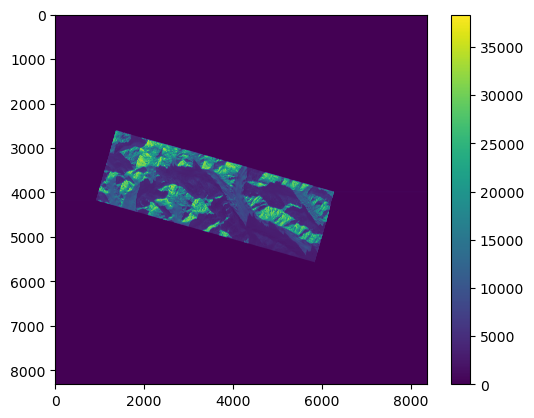

20201106_191910_77_106d_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (6031, 2710)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201106_191910_77_106d_3B_AnalyticMS_SR_clip_5m.tif
20201106_191910_77_106d_3B_AnalyticMS_SR_clip.tif resampled
0.0 11769.605478302845


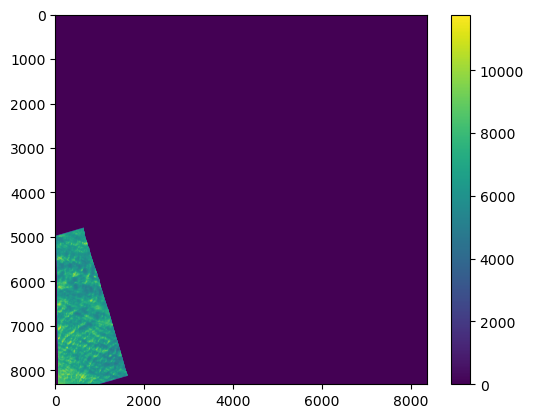

20201102_201457_0f15_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (2262, 923)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201102_201457_0f15_3B_AnalyticMS_SR_clip_5m.tif
20201102_201457_0f15_3B_AnalyticMS_SR_clip.tif resampled
0.0 4482.463884127415


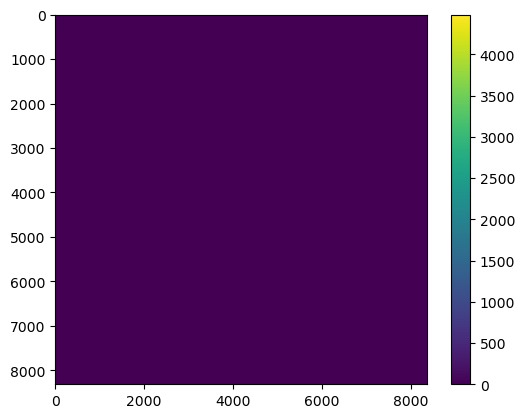

20201115_203633_58_227a_3B_AnalyticMS_SR_clip.tif
32607
EPSG:32607
4
Image dimensions: (1621, 10698)
Resample to DSM dimensions: (8315, 8357)
Save resampled image to 20201115_203633_58_227a_3B_AnalyticMS_SR_clip_5m.tif
20201115_203633_58_227a_3B_AnalyticMS_SR_clip.tif resampled
0.0 11588.645066857409


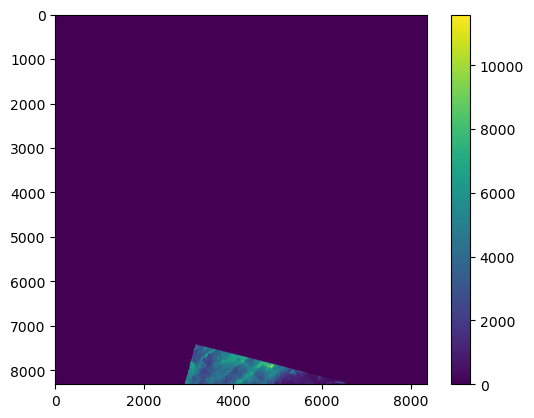

All images resampled.


In [122]:
imgpath = '/Volumes/SGlacier/Turner20_21/11_20/' # enter path to folder with all the images to resample
outpath = '/Volumes/SGlacier/Turner20_21/11_20/out/'
for imgname in os.listdir(imgpath): # loop through all images
    if imgname.endswith("SR_harmonized_clip.tif"): # some sort of condition to make sure the correct tif file is grabbed
        print(imgname)
        #print(imgname)
        #img = rio.open(imgpath+imgname) # open using rasterio
        #nir = img.read(4) # grab the NIR band, 4
        #print("Image dimensions:",nir.shape)
        ## grab the x and y grid values for the DSM
        #img_x = np.linspace(img.bounds.left, img.bounds.right, num=np.shape(nir)[1])
        #img_y = np.linspace(img.bounds.top, img.bounds.bottom, num=np.shape(nir)[0])
        
        if not os.path.exists(imgpath + 'reprojected/'):
            os.mkdir(imgpath + 'reprojected/')

        raster = gdal.Open(imgpath + imgname)
        projstg = raster.GetProjection()
        imgcrs = projstg.split('EPSG')[-1][3:8]
        print(imgcrs)
        print(dsm.crs)

        if 'EPSG:' + imgcrs != str(dsm.crs):
            gdal.Warp(imgpath + 'reprojected/' + imgname, imgpath + imgname, dstSRS=str(dsm.crs))
            print('reprojecting' + imgname)
        else:
            shutil.copy(imgpath + imgname, imgpath + 'reprojected/'+ imgname)
        
#         #Lines 13 through 48 are to put all images into same UTM zone as the DSM
#         with rio.open(imgpath + imgname) as img:
#             if img.crs != dsm.crs:    
#                 nir = img.read(4) # grab the NIR band, 4
#                 print ('reprojecting')
#                 img, dest_transform = reproject(source=nir,
#                         destination=elev,
#                         src_transform=img.transform,
#                         src_crs=img.crs,
#                         dst_transform=dsm.transform,
#                         dst_crs=dsm.crs,
#                         resampling=Resampling.nearest)
        
#                 with rio.open(imgpath + imgname,'w',
#                           driver='GTiff',
#                           height=elev.shape[0],
#                           width=elev.shape[1],
#                           dtype=elev.dtype,
#                           count=1,
#                           crs=dsm.crs,
#                           transform=dsm.transform) as dst:
#                     dst.write(img, 1)

        img = rio.open(imgpath + 'reprojected/'+ imgname) # open using rasterio
        img_data = img.read() # grab the NIR band, 4

        print(len(img_data))
        if len(img_data) == 4:
            nir = img_data[3]
        elif len(img_data) == 1:
            nir = img_data[0]

        print("Image dimensions:",nir.shape)
        # grab the x and y grid values for the DSM
        img_x = np.linspace(img.bounds.left, img.bounds.right, num=np.shape(nir)[1])
        img_y = np.linspace(img.bounds.top, img.bounds.bottom, num=np.shape(nir)[0])
        
        # resample
        f = interp2d(img_x, img_y, nir) # create img interpolation object
        nir_resamp = np.zeros(np.shape(elev)) # initialize resampled image with DSM shape
        nir_resamp = f(dsm_x,dsm_y) # resample the NIR data to the DSM coordinates
        nir_resamp = np.flipud(nir_resamp) # flip up down
        print("Resample to DSM dimensions:",elev.shape)
            
#         if np.nanmax(nir_resamp) == np.nanmin(nir_resamp):
#             dsrt = imgname[:-26]
#             print(dsrt)
#             os.remove(imgpath + imgname) # this removes the SR_clip.tif
#             os.remove(imgpath + dsrt + '_3B_AnalyticMS_DN_udm_clip.tif')
#             os.remove(imgpath + dsrt + '_3B_AnalyticMS_metadata_clip.xml')
#             os.remove(imgpath + dsrt + '_metadata.json')
#             print(dsrt + ' deleted')
        
#         else:
        if True:
            # save the resampled image to georeferenced tif file
            outfile = imgname[:-4]+'_5m.tif' # generate new filename with 5m suffix
            print("Save resampled image to", outfile)
            with rio.open(outpath+outfile,'w',
                                driver='GTiff',
                                height=nir_resamp.shape[0],
                                width=nir_resamp.shape[1],
                                dtype=nir_resamp.dtype,
                                count=1,
                                crs=dsm.crs,
                                transform=dsm.transform) as dst:
                    dst.write(nir_resamp, 1)
            print(imgname + ' resampled')
            print(np.nanmin(nir_resamp), np.nanmax(nir_resamp))
            
            plt.imshow(nir_resamp)
            plt.colorbar()
            plt.show()
            
print("All images resampled.")